In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle
import glob
# import gzip
import scipy
import time
import gc

import sklearn.cluster
  
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

# import ipywidgets as widgets#  HBox, VBox, IntSlider, Play, jslink, Layout, Label

import os

In [2]:
import functions_definitions as rat

In [3]:
import importlib
importlib.reload(rat)

<module 'functions_definitions' from '/Users/jacob/Library/CloudStorage/Dropbox/Foraging as a decision problem/Mate-Data-Collab/code/functions_definitions.py'>

# Data Import

In [4]:
resultsdir = '../../code/savedresults/'
datadir = '/Users/jacob/Library/CloudStorage/Dropbox/Foraging as a decision problem/Mate-Data-Collab/data_for_upload/'

In [5]:
imagedir = '../image-output/'
dfdata = pd.read_csv(datadir+'metrics.csv')
dfgroupnames = pd.read_csv(datadir+'groupnames.csv')
dfAA = pd.read_csv(datadir+'Networks-Period1+Period3.csv')
dfuidlabels = pd.read_csv(datadir+'uidlabels.csv',index_col=0)

allscores = pd.read_csv(datadir+'IndividualTests.csv',index_col='ID')
pairedtests = pd.read_csv(datadir+'PairedTests.csv',index_col='rat_ID')

# Definitions and data processing

In [6]:
absolutemetrics = ['Food', 'DistFromWall', 'Heatmap', 'Hometop']


In [7]:
# uids = dfdata.columns[2:]
groupnames = dfgroupnames[rat.uids].loc[0].values
groupnames_int = np.zeros_like(groupnames)
groups = np.unique(groupnames)
for i,group in enumerate(groups):
    groupnames_int[groupnames==group]=i

groupnames_new = dfgroupnames[rat.uids].loc[3]
groupnames_new_int = np.zeros_like(groupnames_new)
groupsnew = np.unique(groupnames_new)
for i,group in enumerate(groupsnew):
    groupnames_new_int[groupnames_new==group]=i

ratnames=groupnames.copy()
for i in range(len(ratnames)):
    ratnames[i] = ratnames[i]+'-'+str(np.mod(i,7)+1)
ratnames_new = groupnames_new.copy()
for i in range(len(ratnames_new)):
    ratnames_new[i] = ratnames_new[i]+'-'+str(np.mod(i,7)+1)

metrics = np.unique(dfdata['metric'])

## Individual degree

In [8]:
dfdegree = pd.DataFrame(columns=['ID','Experiment','in-degree','out-degree'])
dfdegree_blank = dfdegree.copy()

time='Night'
# loop through experiments and groups, to calculate and save

## PERIOD 1
for e in range(1,8):
    for g in rat.groupselnames:
        dfsel = rat.df_to_dfnetwork(dfAA[(dfAA['Experiment']==(e))&(dfAA['Group']==g)&(dfAA['DayNight']==time)])
        # dfsel = all_exp1dfs[e][g+(0 if time=='Day' else 4)]
        indeg,outdeg = rat.get_indegree(dfsel),rat.get_outdegree(dfsel)
        totaldeg = indeg+outdeg
        localreaching = rat.get_localreaching(dfsel)
        single = dfdegree_blank.copy()
        single['ID'] = indeg.index.values
        single['Experiment'] = e
        single['in-degree'] = indeg.values
        single['out-degree'] = outdeg.values   
        single['Reaching centrality'] = localreaching
        dfdegree = pd.concat((dfdegree,single))
        
## PERIOD 3
for e in range(10,13):
    for g in rat.groupselnamesG:
        dfsel = rat.df_to_dfnetwork(dfAA[(dfAA['Experiment']==(e))&(dfAA['Group']==g)&(dfAA['DayNight']==time)])
        indeg,outdeg = rat.get_indegree(dfsel),rat.get_outdegree(dfsel)
        totaldeg = indeg+outdeg        
        localreaching = rat.get_localreaching(dfsel)
        single = dfdegree_blank.copy()
        single['ID'] = indeg.index.values
        single['Experiment'] = e
        single['in-degree'] = indeg.values
        single['out-degree'] = outdeg.values   
        single['Reaching centrality'] = localreaching        
        dfdegree = pd.concat((dfdegree,single))    

## Add colors and linestyles for plotting to dfuidlabels

In [9]:
# plot colors and styles for each individual, when based on groups
# min in sort order:  dashed
# max in sort order:  solid

# colors based on other groups are easy
dfuidlabels['P3gc_ind'] = groupnames_new_int + 4
dfuidlabels['P1gc_ind'] = groupnames_int
# line styles are hard, because they depend on the sort order!
# for linestyle:  loop through period 3 groups first
dfuidlabels['linestyle'] = np.nan
for group in rat.groupselnamesG:
    sel = dfuidlabels['GroupG']==group
    for og in rat.groupselnames:
        sel2 = sel&(dfuidlabels['Group']==og)
        dfsel = dfuidlabels[sel2].sort_values('GroupMassRank-Exp7')
        for i,uid in enumerate(dfsel.index):
            dfuidlabels.loc[uid,'linestyle'] = ['-','--'][i]

# (Stats) strain comparison of space use

In [10]:
df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=20])
expnums = np.unique(df['Experiment'])
# add a column to this df for the strain, so can make an easier comparison
df['strain'] = np.nan
for u in rat.uids:
    sel = df['ID']==u
    df.loc[sel,'strain'] = dfuidlabels.loc[u,'Group'][0]

In [11]:
print('Treating each experiment and rat as independent (not a good assumption - exps are not independent b/c its the same rats)')
for m in absolutemetrics:
    stat, pvalue = scipy.stats.ttest_ind(df.loc[df['strain']=='A',m],df.loc[df['strain']=='B',m],nan_policy='omit')
    print(m,': p=',pvalue)

Treating each experiment and rat as independent (not a good assumption - exps are not independent b/c its the same rats)
Food : p= 0.24423648083491342
DistFromWall : p= 3.1008035716471896e-26
Heatmap : p= 4.929352792283668e-07
Hometop : p= 4.450790122169521e-23


In [12]:
uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[absolutemetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

In [13]:
print('Treating each rat as independent')
means_per_rat = np.nanmean(all_perratdatamat,axis=1)
for i,m in enumerate(absolutemetrics):
    stat, pvalue = scipy.stats.ttest_ind(means_per_rat[0:14,i],means_per_rat[14:28,i],nan_policy='omit')
    print(m,': p=',pvalue)

Treating each rat as independent
Food : p= 0.4319755948649129
DistFromWall : p= 1.930439890999718e-06
Heatmap : p= 0.0015905114499540208
Hometop : p= 1.7499659849915648e-06


# (Figs 2, 5, S5): individual behavior

## Period 1 - individual metrics

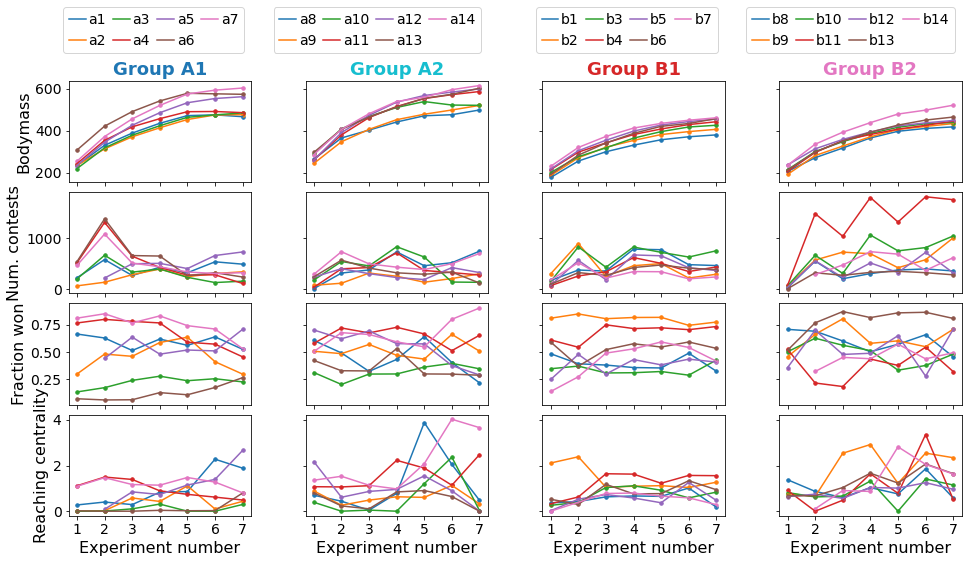

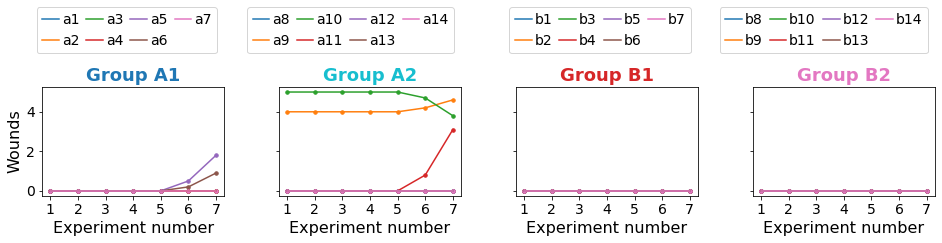

In [84]:
colors_by_p3groups = False

toplotmetrics1 = ['Bodymass','Num. contests','Fraction won','Reaching centrality']
for toplotmetrics,savename in zip([toplotmetrics1,['Wounds']],['metricsp1','woundsp1']):


    df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=7],dfdegree)
    expnums = np.unique(df['Experiment'])

    # 'Heatmap' does not exist for expnum 11.  options are
    # 1) Dont use Heatmap
    # 2) Dont use expnum 11
    # 3) Fill in expnum 11 Heatmap with expnum 12 Heatmap values
    ### --> I will use 3
    df.loc[df['Experiment']==11,'Heatmap'] = df.loc[df['Experiment']==12,'Heatmap'].values

    uids_pca = np.array(df['ID'])
    uids_pca_int = np.zeros(len(uids_pca))
    for i,uid in enumerate(rat.uids):
        uids_pca_int[uids_pca==uid] = i
    expnums_pca = np.array(df['Experiment'])
    datamat = np.array(df[toplotmetrics]).astype(float) 

    all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
    for i,uid in enumerate(rat.uids):
        all_perratdatamat[i] = datamat[uids_pca_int==i]
        if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
            print('ERROR')


    f,ax = plt.subplots(len(toplotmetrics),4,sharey='row',sharex=True)
    if len(toplotmetrics)==1:
        ax = np.array([ax])
    f.set_size_inches(16,len(ax)*2)
    tpx = np.arange(len(expnums))
    for i,group in enumerate(rat.groupselnames):
        groupsel = (groupnames==group)
        uiddata = rat.uids[groupsel]
        gdata = all_perratdatamat[groupsel]
        for j,metric in enumerate(toplotmetrics):
            a=ax[j,i]
            for kcolor,k in enumerate(np.argsort(dfuidlabels.loc[uiddata,'GroupMassRank-Exp7'].values)):  # each rat in the group
                uid = uiddata[k]
                color = rat.groupcolors[dfuidlabels.loc[uid,'P3gc_ind']] if colors_by_p3groups else rat.snscolors[kcolor]
                linestyle=dfuidlabels.loc[uid,'linestyle'] if colors_by_p3groups else '-'
                a.plot(tpx,gdata[k,:,j],label=dfuidlabels.loc[uid,'masslabel'],color=color,linestyle=linestyle)
                a.scatter(tpx,gdata[k,:,j],color=color,s=12)            
            a.set_xticks(tpx)
            a.set_xticklabels(expnums)
            a.tick_params(labelsize=14)        
            if np.max(expnums)>20:
                a.axvline(6.5,c='grey',linewidth=1)
            if np.max(expnums)>23:
                a.axvline(8.5,c='grey',linewidth=1)            

    for a in ax[0]:
        a.legend(bbox_to_anchor=(1,1.8),fontsize=14, ncol=4, handletextpad=0.2, columnspacing=0.5, handlelength=1.2)


    for a,metric in zip(ax[:,0],toplotmetrics):
        a.set_ylabel(metric,fontsize=16)
    for a,group,color in zip(ax[0],rat.groupselnames,rat.groupcolors):
        a.set_title('Group '+group,fontsize=18,color=color,fontweight="bold")
    [a.set_xlabel('Experiment number',fontsize=16) for a in ax[-1,:]]
    plt.subplots_adjust(wspace=0.3,hspace=0.1)
    plt.savefig(imagedir+savename+'.pdf')
    plt.show()

## Period 3 - individual metrics

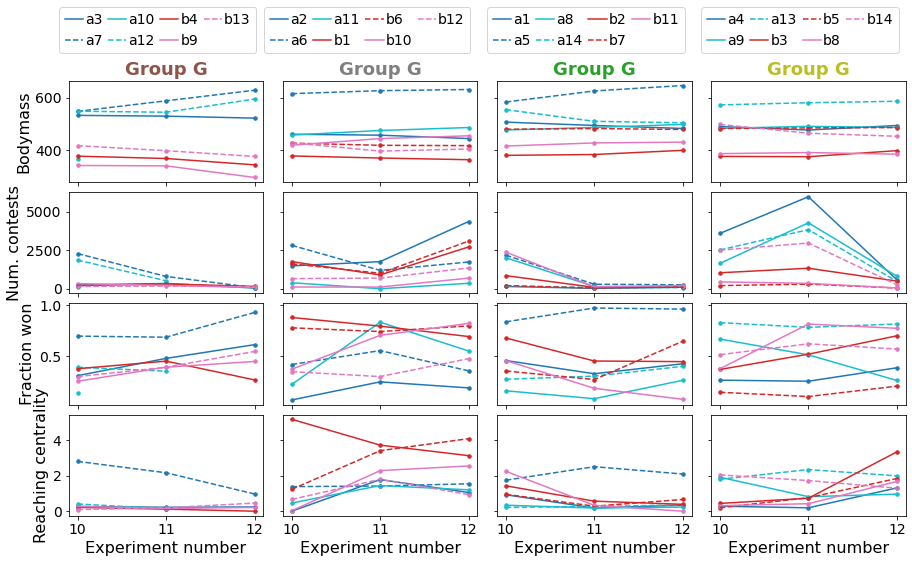

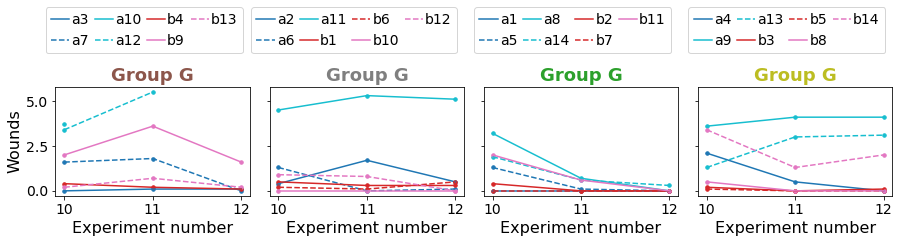

In [85]:
toplotmetrics1 = ['Bodymass','Num. contests','Fraction won','Reaching centrality']
for toplotmetrics,savename in zip([toplotmetrics1,['Wounds']],['metricsp3','woundsp3']):



    df = rat.dfdata_to_dfpca(dfdata[(dfdata['Experiment']>=10)&(dfdata['Experiment']<=12)],dfdegree)
    expnums = np.unique(df['Experiment'])

    # 'Heatmap' does not exist for expnum 11.  options are
    # 1) Dont use Heatmap
    # 2) Dont use expnum 11
    # 3) Fill in expnum 11 Heatmap with expnum 12 Heatmap values
    ### --> I will use 3
    df.loc[df['Experiment']==11,'Heatmap'] = df.loc[df['Experiment']==12,'Heatmap'].values

    uids_pca = np.array(df['ID'])
    uids_pca_int = np.zeros(len(uids_pca))
    for i,uid in enumerate(rat.uids):
        uids_pca_int[uids_pca==uid] = i
    expnums_pca = np.array(df['Experiment'])
    datamat = np.array(df[toplotmetrics]).astype(float) 

    all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
    for i,uid in enumerate(rat.uids):
        all_perratdatamat[i] = datamat[uids_pca_int==i]
        if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
            print('ERROR')

    massorder = []
    for i,u in enumerate(rat.uids):
        massorder.append( int(uidmasslabels[u][-1]) + 7*groupnames_int[i] )
    uidmassorder = dict(zip(rat.uids,massorder))

    f,ax = plt.subplots(len(toplotmetrics),4,sharey='row',sharex=True)
    if len(toplotmetrics)==1:
        ax = np.array([ax])
    f.set_size_inches(15,len(ax)*2)
    tpx = np.arange(len(expnums))
    for i,group in enumerate(rat.groupselnamesG):
        groupsel = (groupnames_new==group)
        uiddata = rat.uids[groupsel]
        gdata = all_perratdatamat[groupsel]
        for j,metric in enumerate(toplotmetrics):
            a=ax[j,i]
            for kcolor,k in enumerate(np.argsort([(0 if uidmasslabels[u][0]=='a' else 100) + int(uidmasslabels[u][1:]) for u in uiddata])):  # each rat in the group
                uid = uiddata[k]
                a.plot(tpx,gdata[k,:,j],label=uidmasslabels[uid],
                      # color=snscolors[kcolor])
                  color=rat.groupcolors[dfuidlabels.loc[uid,'P1gc_ind']],linestyle=dfuidlabels.loc[uid,'linestyle'])
                a.scatter(tpx,gdata[k,:,j],color=rat.groupcolors[dfuidlabels.loc[uid,'P1gc_ind']],s=12)
            a.set_xticks(tpx)
            a.set_xticklabels(expnums)
            a.tick_params(labelsize=14)               

    for a in ax[0]:
        a.legend(bbox_to_anchor=(1,1.8),fontsize=14, ncol=4, handletextpad=0.15, columnspacing=0.4, handlelength=1.3)
    for a,metric in zip(ax[:,0],toplotmetrics):
        a.set_ylabel(metric,fontsize=16)
    for a,group,color in zip(ax[0],rat.groupselnamesG,rat.groupcolors[4:]):
        a.set_title('Group '+group[0:-1],fontsize=18,color=color,fontweight="bold")
    [a.set_xlabel('Experiment number',fontsize=16) for a in ax[-1,:]]
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    plt.savefig(imagedir+savename+'.pdf')
    plt.show()

# (Figs 2, 5): Group-level metrics

In [111]:
groupmetrics = absolutemetrics

In [112]:
### exps 123
df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=7],dfdegree)
expnums = np.unique(df['Experiment'])
print(expnums)

# 'Heatmap' does not exist for expnum 11.  options are
# 1) Dont use Heatmap
# 2) Dont use expnum 11
# 3) Fill in expnum 11 Heatmap with expnum 12 Heatmap values
### --> I will use 3
df.loc[df['Experiment']==11,'Heatmap'] = df.loc[df['Experiment']==12,'Heatmap'].values

uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[groupmetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

# get mean std
groupmeans = []
groupstds = []
groupselnames = ['A1','A2','B1','B2']
for whichgroup in groupselnames:
    gsel = groupnames==whichgroup
    pergroupmean = np.mean(all_perratdatamat[gsel], axis=0)
    pergroupstd = np.std(all_perratdatamat[gsel], axis=0)    
    groupmeans.append(pergroupmean)
    groupstds.append(pergroupstd)

numexps=7
rf = lambda x: np.reshape(np.array(x)[:,0:numexps,:],(-1,len(groupmetrics)))
grouppcamat = np.hstack((rf(groupmeans),rf(groupstds)))
grouppcamat_colnames = np.concatenate(([m+'-mean' for m in groupmetrics],[m+'-std' for m in groupmetrics]))

groupnames123 = np.reshape([np.tile(g,numexps) for g in groupselnames],-1) 
expnames123 = np.tile(expnums.astype(int),4)
groupexpnames123 = [str(a)+'-'+str(b) for a,b in zip(groupnames123,expnames123)]

# don't remove anymore, because its easier to organize
# toremove = (np.std(grouppcamat,axis=0)<1e-5)
toremove = np.tile(False,len(grouppcamat_colnames))
print('removed',grouppcamat_colnames[toremove])
grouppcamat123 = grouppcamat[:,np.logical_not(toremove)].copy()
grouppcamat_colnames = grouppcamat_colnames[np.logical_not(toremove)]

[1 2 3 4 5 6 7]
removed []


In [117]:
### exps 456.

SIZEORDER = False  ## for experiments

# there are multiple settings different for this (e.g. group names, filtering nan rats), so keep this separate
df = rat.dfdata_to_dfpca(dfdata[(dfdata['Experiment']>=10) & (dfdata['Experiment']<=12)],dfdegree)
expnums = np.unique(df['Experiment'])
print(expnums)

rats_withnans = ['OBP','RBP']
tokeepmask = np.tile(True,len(rat.uids))
for u in rats_withnans:
    tokeepmask[np.where(rat.uids==u)[0][0]] = False
uids_withdata = rat.uids[tokeepmask]
groupnames_withdata = groupnames[tokeepmask]
groupnames_new_withdata = groupnames_new[tokeepmask]
ratnames_withdata = ratnames[tokeepmask]
ratnames_new_withdata = ratnames_new[tokeepmask]
withnans = (df['ID']==rats_withnans[0]) | (df['ID']==rats_withnans[1])

uids_pca = np.array(df['ID'])
uids_pca_int = np.tile(-1,len(uids_pca)).astype(int)
for i,uid in enumerate(uids_withdata):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[groupmetrics]).astype(float) 


all_perratdatamat = np.tile(np.nan,(len(uids_withdata),len(expnums),datamat.shape[1]))
# switch order, to keep consistency, normal->large->small
for i,uid in enumerate(uids_withdata):
    gnames = dfgroupnames[uid][3:6]
    if SIZEORDER:        
        all_perratdatamat[i] = datamat[uids_pca_int==i][np.argsort(gnames)]
    else:
        all_perratdatamat[i] = datamat[uids_pca_int==i]

# means of new groups 'G*'
groupmeansG = []
groupstdsG = []
groupselnamesG = ['G1','G2','G3','G4']

    
for whichgroup in groupselnamesG:
    gsel = groupnames_new_withdata==whichgroup
    pergroupmean = np.nanmean(all_perratdatamat[gsel], axis=0)
    pergroupstd = np.nanstd(all_perratdatamat[gsel], axis=0)
    groupstdsG.append(pergroupstd)
    groupmeansG.append(pergroupmean)


numexps=3
rf = lambda x: np.reshape(np.array(x)[:,0:numexps,:],(-1,len(groupmetrics)))
grouppcamat = np.hstack((rf(groupmeansG),rf(groupstdsG)))

groupnames456 = np.reshape([np.tile(g,numexps) for g in groupselnamesG],-1) 
expnames456 = np.tile(expnums.astype(int),4)
groupexpnames456 = [str(a)+'-'+str(b) for a,b in zip(groupnames456,expnames456)]

grouppcamat456 = grouppcamat[:,np.logical_not(toremove)].copy()

[10 11 12]


In [118]:
## Dataframe with these group averages. for plotting and selecting below
dfgroup = pd.DataFrame(np.vstack((grouppcamat123,grouppcamat456)).copy(),columns=grouppcamat_colnames)
dfgroup.insert(0,'Group',np.concatenate((groupnames123,groupnames456)) )
dfgroup.insert(1,'Experiment',np.concatenate((expnames123,expnames456)) )
dfgroup.head()

Group  Experiment  Food-mean  DistFromWall-mean  Heatmap-mean  Hometop-mean  \
0    A1           1   0.040388          56.314286           NaN      0.021984   
1    A1           2   0.033171          53.000000      0.007660      0.018219   
2    A1           3   0.024081          54.700000      0.006449      0.033811   
3    A1           4   0.035977          52.614286      0.006745      0.034183   
4    A1           5   0.036090          60.385714      0.007574      0.041820   

   Food-std  DistFromWall-std  Heatmap-std  Hometop-std  
0  0.019437          7.479769          NaN     0.029640  
1  0.018511          5.619609     0.002281     0.017668  
2  0.005803          5.549517     0.001287     0.022456  
3  0.008243          4.883625     0.001237     0.023485  
4  0.011120          9.832225     0.001579     0.030590

In [125]:
### PREDICTIONS for exp456, based on last exp in Period 1
df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']==7],dfdegree)
expnums = np.unique(df['Experiment'])
print(expnums)

uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[groupmetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

# get mean std
groupmeans = []
groupstds = []
for whichgroup in groupselnamesG:
    gsel = groupnames_new==whichgroup
    pergroupmean = np.mean(all_perratdatamat[gsel], axis=0)
    pergroupstd = np.std(all_perratdatamat[gsel], axis=0)    
    groupmeans.append(pergroupmean)
    groupstds.append(pergroupstd)

numexps=1
rf = lambda x: np.reshape(np.array(x)[:,0:numexps,:],(-1,len(groupmetrics)))
grouppcamat = np.hstack((rf(groupmeans),rf(groupstds)))
grouppcamat_colnames = np.concatenate(([m+'-mean' for m in groupmetrics],[m+'-std' for m in groupmetrics]))

groupnames_pred = np.reshape([np.tile(g,numexps) for g in groupselnamesG],-1) 
expnames_pred = np.tile(expnums.astype(int),4)

# don't remove anymore, because its easier to organize
# toremove = (np.std(grouppcamat,axis=0)<1e-5)
toremove = np.tile(False,len(grouppcamat_colnames))
print('removed',grouppcamat_colnames[toremove])
grouppcamat_pred = grouppcamat[:,np.logical_not(toremove)].copy()
grouppcamat_colnames = grouppcamat_colnames[np.logical_not(toremove)]

dfgroup_pred = pd.DataFrame(grouppcamat_pred,columns=grouppcamat_colnames)
dfgroup_pred.insert(0,'Group',groupnames_pred)
dfgroup_pred.insert(1,'Experiment',expnames_pred )
dfgroup_pred.head()

[7]
removed []


Group  Experiment  Food-mean  DistFromWall-mean  Heatmap-mean  Hometop-mean  \
0    G1           7   0.032971          45.471429      0.006561      0.111376   
1    G2           7   0.043829          45.700000      0.006572      0.093556   
2    G3           7   0.043909          48.400000      0.006954      0.074198   
3    G4           7   0.055029          40.885714      0.005812      0.060802   

   Food-std  DistFromWall-std  Heatmap-std  Hometop-std  
0  0.006507          8.464331     0.001073     0.073114  
1  0.007961          8.146691     0.000968     0.080002  
2  0.009517          9.503082     0.000723     0.038386  
3  0.014537          7.359819     0.000856     0.038764

## Period 1 - group metrics

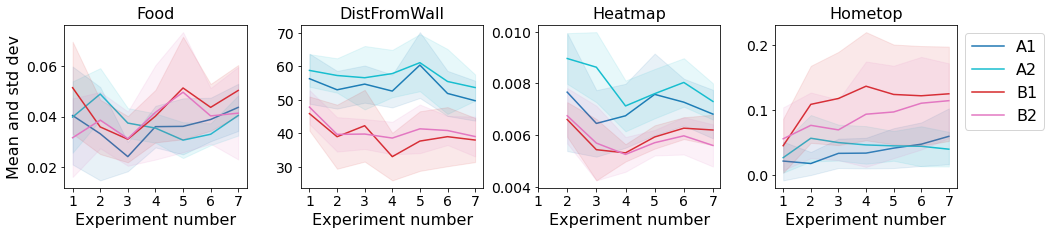

In [128]:
# Period 1
expsel=dfgroup['Experiment']<20
coloroffset = 0
gselname = groupselnames
toplotmetricsall = absolutemetrics

expnums = np.unique(dfgroup.loc[expsel,'Experiment'])
toplotmetrics = absolutemetrics
f,ax = plt.subplots(1,len(toplotmetrics),sharex=False)
f.set_size_inches(4*len(toplotmetrics),3)
for i,m in enumerate(toplotmetrics):
    a=ax[i]
    for j,g in enumerate(gselname):
        tpx, tpmean, tpstd =  dfgroup.loc[expsel&(dfgroup['Group']==g),['Experiment',m+'-mean',m+'-std']].T.values
        c = rat.groupcolors[j+coloroffset]
        a.plot(tpx,tpmean,color=c,zorder=1,label=g)
        a.fill_between(tpx,tpmean-tpstd,tpmean+tpstd,color=c,alpha=0.1)
    a.set_title(m,fontsize=16)
ax[0].set_ylabel('Mean and std dev',fontsize=16)    
ax[-1].legend(fontsize=16,bbox_to_anchor=(1,1))

for a in ax:
    a.tick_params(labelsize=14)
    a.set_xticks(tpx)
    # a.set_xticklabels([expnumlabels[e] for e in expnums])
    a.set_xlabel('Experiment number',fontsize=16)

plt.subplots_adjust(wspace=0.3)
plt.savefig(imagedir+'p1groupgroupmetrics.pdf')
plt.show()



## Period 3 group metrics and predictions

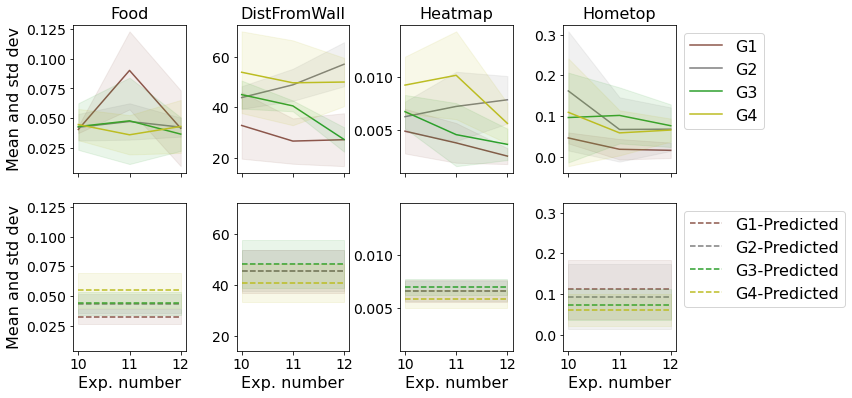

In [131]:
# PERIOD 3
expsel = dfgroup['Experiment']>=10
coloroffset = 4
gselname = groupselnamesG

expnums = np.unique(dfgroup.loc[expsel,'Experiment'])
toplotmetrics = absolutemetrics
f,ax = plt.subplots(2,len(toplotmetrics),sharex=True,sharey='col')
f.set_size_inches(2.7*len(toplotmetrics),3*2)
for i,m in enumerate(toplotmetrics):
    a=ax[0,i]
    a2 = ax[1,i]
    for j,g in enumerate(gselname):
        c = rat.groupcolors[j+coloroffset]
        tpx, tpmean, tpstd =  dfgroup.loc[expsel&(dfgroup['Group']==g),['Experiment',m+'-mean',m+'-std']].T.values
        a.plot(tpx,tpmean,color=c,zorder=1,label=g)
        a.fill_between(tpx,tpmean-tpstd,tpmean+tpstd,color=c,alpha=0.1)
        tpmean, tpstd =  dfgroup_pred.loc[dfgroup_pred['Group']==g,[m+'-mean',m+'-std']].T.values
        tpmean = np.tile(tpmean,len(tpx))
        tpstd = np.tile(tpstd,len(tpx))
        a2.plot(tpx,tpmean,color=c,zorder=1,label=g+'-Predicted',linestyle='--')      
        a2.fill_between(tpx,tpmean-tpstd,tpmean+tpstd,color=c,alpha=0.1)        
    a.set_title(m,fontsize=16)
[a.set_ylabel('Mean and std dev',fontsize=16) for a in ax[:,0]]
[a.legend(fontsize=16,bbox_to_anchor=(1,1)) for a in ax[:,-1]]

for a in ax.flatten():
    a.tick_params(labelsize=14)
    a.set_xticks(tpx)
    # a.set_xticklabels([expnumlabels[e] for e in expnums])
for a in ax[-1]:    
    a.set_xlabel('Exp. number',fontsize=16)

plt.subplots_adjust(wspace=0.45,hspace=0.2)
plt.savefig(imagedir+'p3groupgroupmetrics.pdf')
plt.show()



## P1 and P3 network metrics

In [ ]:
networkmetricfunctions = [rat.getmeancontests,rat.get_transitivityindex_ordered,rat.get_symmetryindex,
                         lambda x: rat.get_symmetryindex_special(x,which='rest'), lambda x: rat.get_symmetryindex_special(x,which='dominantonly'), 
                          rat.get_degreefrac_special,rat.get_reaching_gini] 
networkmetrics_base = ['Mean num. contests','Transitivity index','Symmetry index',
                      'Symmetry: non-dominant', 'Symmetry: dominant',
                       'Frac. dominant contests','Reaching centrality Gini coeff'] 

# Loop through, calculate, and add these the matrix
# Period 1
for e in np.arange(1,8):
    for g in rat.groupselnames:
        for time in ['Day','Night']:
            network = rat.df_to_dfnetwork( dfAA[(dfAA['Experiment']==e)&(dfAA['Group']==g)&(dfAA['DayNight']==time)] )
            for fn,m in zip(networkmetricfunctions,networkmetrics_base):
                dfgroup.loc[(dfgroup['Experiment']==e)&(dfgroup['Group']==g),m+'-'+time] = fn(network)
            
# Period 1
for e in np.arange(10,13):
    for g in rat.groupselnamesG:
        for time in ['Day','Night']:
            network = rat.df_to_dfnetwork( dfAA[(dfAA['Experiment']==e)&(dfAA['Group']==g)&(dfAA['DayNight']==time)] )
            for fn,m in zip(networkmetricfunctions,networkmetrics_base):
                dfgroup.loc[(dfgroup['Experiment']==e)&(dfgroup['Group']==g),m+'-'+time] = fn(network)            

In [163]:
networkmetrics = []
for m in networkmetrics_base:
    # networkmetrics.append(m+'-Day')
    networkmetrics.append(m+'-Night')

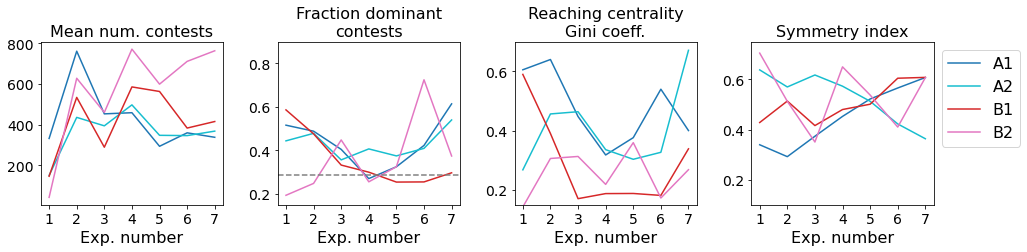

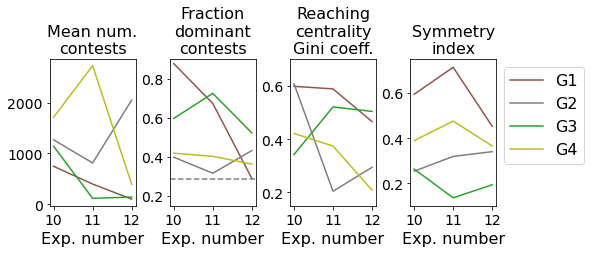

In [166]:
savefigures = True
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages(imagedir+'Group-NetworkMetrics.pdf')

# Exp 1, Exp 456
expsels = [(dfgroup['Experiment']<=7),(dfgroup['Experiment']>=10)&(dfgroup['Experiment']<=12)]
coloroffsets = [0,4]
gselnames = [rat.groupselnames,rat.groupselnamesG]
toplotmetrics = ['Mean num. contests','Frac. dominant contests','Reaching centrality Gini coeff','Symmetry index']
titlenames = [['Mean num. contests','Fraction dominant\ncontests','Reaching centrality\nGini coeff.','Symmetry index'],
              ['Mean num.\ncontests','Fraction\ndominant\ncontests','Reaching\ncentrality\nGini coeff.','Symmetry\nindex']]


for k,(expsel,coloroffset,gselname) in enumerate(zip(expsels,coloroffsets,gselnames)):
    f,ax = plt.subplots(1,len(toplotmetrics),sharex=True,sharey='col')
    f.set_size_inches(4*len(toplotmetrics)*[1,0.5][k],[3,2.7][k])
    for i,m in enumerate(toplotmetrics):
        # a=ax[0,i]
        # a2=ax[1,i]
        a=ax[i]
        for j,g in enumerate(gselname):
            tpx, tpday, tpnight =  dfgroup.loc[expsel&(dfgroup['Group']==g),['Experiment',m+'-Day',m+'-Night']].T.values
            c = rat.groupcolors[j+coloroffset]
            a.plot(tpx,tpnight,color=c,zorder=1,label=g)
            # a2.plot(tpx,tpnight,color=c)
        a.set_title(titlenames[k][i],fontsize=16)
    # ax[0,0].set_ylabel('Day',fontsize=16)    
    # ax[1,0].set_ylabel('Night',fontsize=16)    
    ax[-1].legend(fontsize=16,bbox_to_anchor=(1,1))

    for a in ax.flatten():
        a.tick_params(labelsize=14)
        a.set_xticks(tpx)
    for a in ax:
        a.set_xlabel('Exp. number',fontsize=16)
    ax[1].set_ylim([0.15,0.9])
    ax[2].set_ylim([0.15,0.7])    
    ax[3].set_ylim([0.1,0.75])
    
    # uniform is 2/7.  here's why.  Total num unique pairs is n(n-1)/2.  so, because of the non-uniqueness (i.e. the dividing by 2), the uniform expectation is 2/7, NOT 1/7.  I checked it with a uniform example and its true
    ax[1].axhline(2/7,c='grey',linestyle='--')

    plt.subplots_adjust(wspace=0.3+[0,0.1][k])
    pdf.savefig(f,bbox_inches="tight") if savefigures else None
    plt.show()

pdf.close() if savefigures else None
savefigures=False

# (Figs 3,6): Network visualizations

Note!  The scale is linear, and so excess fraction won (e), is related to fraction won (f), by e=2f-1.  so, can just swap the scale

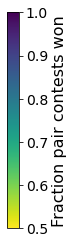

In [169]:
f,ax = plt.subplots(1,1)
f.set_size_inches(0.2,5)

img = plt.imshow(np.array([[0.5,1]]), cmap=rat.cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax)
cbar.set_label('Fraction pair contests won',fontsize=16)
cbar.ax.tick_params(labelsize=14)   
plt.savefig(imagedir+'networkcolorbar.pdf')
plt.show()

## Period 1

[2 3 4 5 6 7]


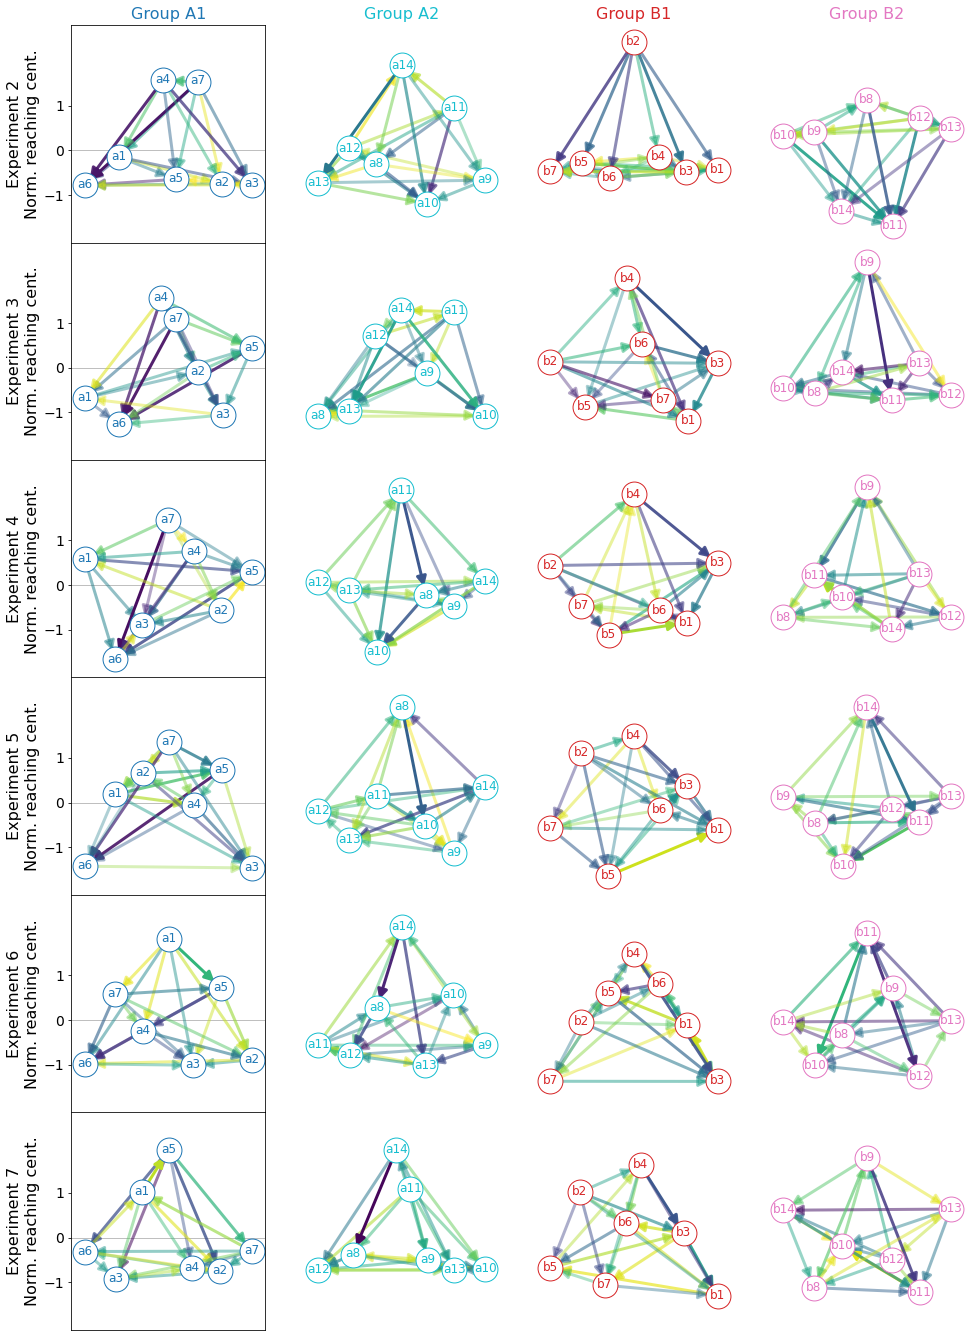

In [181]:
etoshow = np.arange(2,8)
print(etoshow)
labelcolor='k'

time = 'Night'
# for time in ['Day','Night']:

f,ax = plt.subplots(len(etoshow),4,sharey=True)
if len(etoshow)==1:
    ax = np.array([ax])
basesize=4
f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0])
f.set_facecolor('white')


for i,e in enumerate(etoshow):
    for j,g in enumerate(rat.groupselnames):
        a=ax[i,j]
        network = rat.df_to_dfnetwork( dfAA[(dfAA['Experiment']==e)&(dfAA['Group']==g)&(dfAA['DayNight']==time)] )
        rat.showgraph2(network,a,dfuidlabels,widthscale=1/40,which='plt',layout='localreaching')

    ax[i,0].set_ylabel('Experiment '+str(e)+'\nNorm. reaching cent.',fontsize=16,color=labelcolor)
    
for g in range(4):
    ax[0,g].set_title('Group '+groupselnames[g],color=rat.groupcolors[g],fontsize=16)
    
for a in ax.flatten():
    a.axis('off') 
    
for a in ax[:,0]:
    a.tick_params(labelsize=14)
    a.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
    a.set_yticks([-1,0,1])
    a.axis(True)
    a.axhline(0,c='grey',linewidth=0.5,zorder=-10)
    
    

plt.subplots_adjust(hspace=0)

plt.savefig(imagedir+'PD1networks'+str(etoshow)+'.pdf')
plt.show()

## Period 3

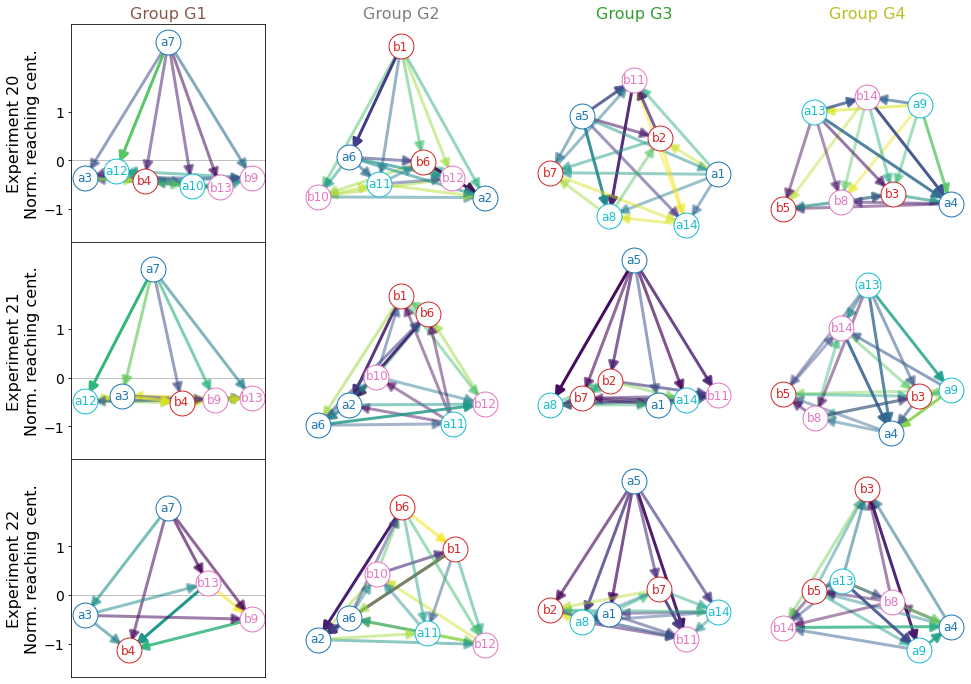

In [182]:
labelcolor='k'
basesize=4
time = 'Night'

etoshow=np.arange(10,13)
f,ax = plt.subplots(len(etoshow),4,sharey=True)
if len(etoshow)==1:
    ax = np.array([ax])
basesize=4
f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0])
f.set_facecolor('white')

for i,e in enumerate(etoshow):
    for j,g in enumerate(rat.groupselnamesG):
        a=ax[i,j]
        network = rat.df_to_dfnetwork( dfAA[(dfAA['Experiment']==e)&(dfAA['Group']==g)&(dfAA['DayNight']==time)] )
        rat.showgraph2(network,a,dfuidlabels,widthscale=1/40,which='plt',layout='localreaching')
    ax[i,0].set_ylabel('Experiment '+str(e+10)+'\nNorm. reaching cent.',fontsize=16,color=labelcolor)
            
for g in range(4):
    ax[0,g].set_title('Group '+groupselnamesG[g],color=rat.groupcolors[4+g],fontsize=16)

for a in ax.flatten():
    a.axis('off') 
    
for a in ax[:,0]:
    a.tick_params(labelsize=14)
    a.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
    a.set_yticks([-1,0,1])
    a.axis(True)
    a.axhline(0,c='grey',linewidth=0.5,zorder=-10)

plt.subplots_adjust(hspace=0)

plt.savefig(imagedir+'PD3networks'+str(etoshow)+'.pdf')
plt.show()

# (Figs 4, S3):  Correlations

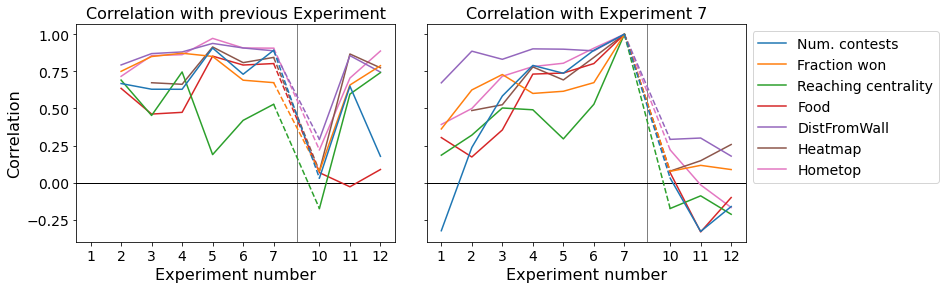

In [88]:
##  With next measurement
othermetrics = ['FQFood', 'FQWater', 'FQWheel', 'FQWhileF', 'FoodCumul']

toplotmetrics = ['Num. contests','Fraction won','Reaching centrality'] + absolutemetrics

df = rat.dfdata_to_dfpca(dfdata[(dfdata['Experiment']<=7)|( (dfdata['Experiment']>=10)&(dfdata['Experiment']<=12) )],dfdegree)
# df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=26])
expnums = np.unique(df['Experiment'])
## dont fill this in for the correlation calculation, it gives a "false score" of 1
# df.loc[df['Experiment']==11,'Heatmap'] = df.loc[df['Experiment']==12,'Heatmap'].values

uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[toplotmetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

corrpermetric = np.tile(np.nan,(len(toplotmetrics),len(expnums)))
for m in range(len(toplotmetrics)):
    for e in range(1,len(expnums)):
        x,y = all_perratdatamat[:,e,m], all_perratdatamat[:,e-1,m]
        nanfilter = np.logical_not(np.isnan(x)|np.isnan(y))
        if np.sum(nanfilter)==0:
            corrpermetric[m,e] = np.nan
        else:
            corrpermetric[m,e] = scipy.stats.pearsonr(x[nanfilter],y[nanfilter])[0]
            
corrpermetric_exp7 = np.tile(np.nan,(len(toplotmetrics),len(expnums)))
for m in range(len(toplotmetrics)):
    for e in range(0,len(expnums)):
        x,y = all_perratdatamat[:,e,m], all_perratdatamat[:,6,m]
        nanfilter = np.logical_not(np.isnan(x)|np.isnan(y))
        if np.sum(nanfilter)==0:
            corrpermetric_exp7[m,e] = np.nan
        else:
            corrpermetric_exp7[m,e] = scipy.stats.pearsonr(x[nanfilter],y[nanfilter])[0]

# make figure
f,ax = plt.subplots(1,2,sharey=True,sharex=True)
f.set_size_inches(12,4)            
            
tpx = np.arange(len(expnums)).astype(float)
tpx[-3:] += 0.5
xticklabels = expnums

a=ax[0]
for a,tp in zip(ax,[corrpermetric,corrpermetric_exp7]):
    for i,m in enumerate(toplotmetrics):
        a.plot(tpx[0:7],tp[i,0:7],label=m,c=rat.snscolors[i],zorder=10-i)
        a.plot(tpx[6:8],tp[i,6:8],linestyle='--',c=rat.snscolors[i],zorder=10-i)
        a.plot(tpx[7:],tp[i,7:],c=rat.snscolors[i],zorder=10-i)
    
ax[0].set_title('Correlation with previous Experiment',fontsize=16)
ax[1].set_title('Correlation with Experiment 7',fontsize=16)
ax[-1].legend(bbox_to_anchor=(1,1),fontsize=14)
ax[0].set_ylabel('Correlation',fontsize=16)

for a in ax:
    a.set_xticks(tpx)
    a.set_xticklabels(xticklabels,fontsize=14)
    a.tick_params(labelsize=14)        
    a.set_xlabel('Experiment number',fontsize=16)
    a.axvline(np.mean((tpx[6:8])),c='gray',linewidth=1,zorder=-1)
    a.axhline(0,c='k',linewidth=1,zorder=-1)
plt.subplots_adjust(wspace=0.1)
plt.savefig(imagedir+'/correlation.pdf')
plt.show()

## S3:  per-group

In [90]:
##  With next measurement
othermetrics = ['FQFood', 'FQWater', 'FQWheel', 'FQWhileF', 'FoodCumul']

toplotmetrics = ['Num. contests','Fraction won','Reaching centrality'] + absolutemetrics

df = rat.dfdata_to_dfpca(dfdata[(dfdata['Experiment']<=7)|( (dfdata['Experiment']>=10)&(dfdata['Experiment']<=12) )],dfdegree)
# df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=26])
expnums = np.unique(df['Experiment'])
## dont fill this in for the correlation calculation, it gives a "false score" of 1
# df.loc[df['Experiment']==11,'Heatmap'] = df.loc[df['Experiment']==12,'Heatmap'].values

uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[toplotmetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

def getcorrs(sel):
    corrpermetric = np.tile(np.nan,(len(toplotmetrics),len(expnums)))
    for m in range(len(toplotmetrics)):
        for e in range(1,len(expnums)):
            x,y = all_perratdatamat[:,e,m], all_perratdatamat[:,e-1,m]
            x,y = x[sel], y[sel]
            nanfilter = np.logical_not(np.isnan(x)|np.isnan(y))
            if np.sum(nanfilter)==0:
                corrpermetric[m,e] = np.nan
            else:
                corrpermetric[m,e] = scipy.stats.pearsonr(x[nanfilter],y[nanfilter])[0]
    corrpermetric_exp7 = np.tile(np.nan,(len(toplotmetrics),len(expnums)))
    for m in range(len(toplotmetrics)):
        for e in range(0,len(expnums)):
            x,y = all_perratdatamat[:,e,m], all_perratdatamat[:,6,m]
            x,y = x[sel], y[sel]            
            nanfilter = np.logical_not(np.isnan(x)|np.isnan(y))
            if np.sum(nanfilter)==0:
                corrpermetric_exp7[m,e] = np.nan
            else:
                corrpermetric_exp7[m,e] = scipy.stats.pearsonr(x[nanfilter],y[nanfilter])[0]
    return corrpermetric,corrpermetric_exp7

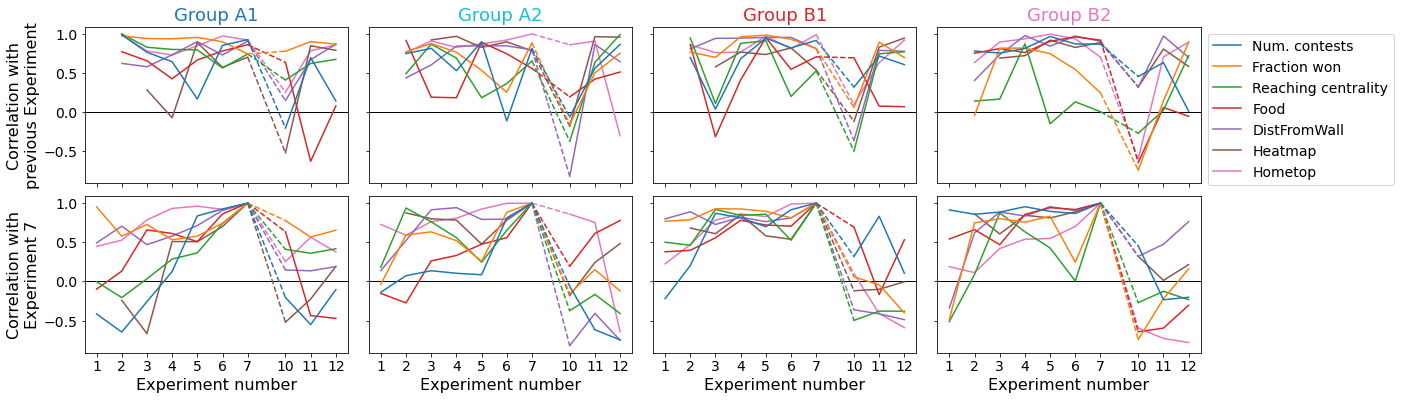

In [91]:
### PERIOD 1 GROUPS

        
# make figure
f,ax = plt.subplots(2,4,sharey=True,sharex=True)
f.set_size_inches(20,6)             
tpx = np.arange(len(expnums)).astype(float)
tpx[-3:] += 0.5
xticklabels = expnums


# calculate and plot for each group
for k,g in enumerate(rat.groupselnames):
    sel = groupnames==g
    corrpermetric,corrpermetric_exp7 = getcorrs(sel)

    for a,tp in zip(ax[:,k],[corrpermetric,corrpermetric_exp7]):
        for i,m in enumerate(toplotmetrics):
            a.plot(tpx[0:7],tp[i,0:7],label=m,c=rat.snscolors[i],zorder=10-i)
            a.plot(tpx[6:8],tp[i,6:8],linestyle='--',c=rat.snscolors[i],zorder=10-i)
            a.plot(tpx[7:],tp[i,7:],c=rat.snscolors[i],zorder=10-i)



ax[0,0].set_ylabel('Correlation with\nprevious Experiment',fontsize=16)
ax[1,0].set_ylabel('Correlation with\nExperiment 7',fontsize=16)
ax[0,-1].legend(bbox_to_anchor=(1,1),fontsize=14)

for i in range(4):
    ax[0,i].set_title('Group '+rat.groupselnames[i],fontsize=18,color=rat.groupcolors[i])
    ax[1,i].set_xlabel('Experiment number',fontsize=16)

    

for a in ax.flatten():
    a.set_xticks(tpx)
    a.set_xticklabels(xticklabels,fontsize=14)
    a.tick_params(labelsize=14)        
    a.axhline(0,c='k',linewidth=1,zorder=-1)

plt.subplots_adjust(wspace=0.08,hspace=0.08)
plt.savefig(imagedir+'correlationPeriod1groups.pdf')
plt.show()

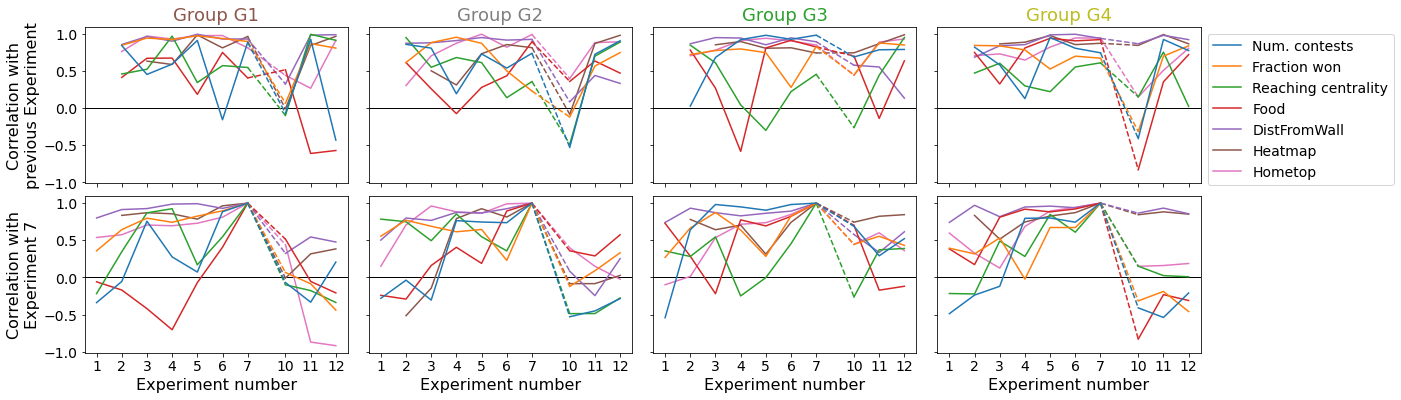

In [93]:
### PERIOD 3 GROUPS

# make figure
f,ax = plt.subplots(2,4,sharey=True,sharex=True)
f.set_size_inches(20,6)             
tpx = np.arange(len(expnums)).astype(float)
tpx[-3:] += 0.5
xticklabels = expnums


# calculate and plot for each group
for k,g in enumerate(rat.groupselnamesG):
    sel = groupnames_new==g
    corrpermetric,corrpermetric_exp7 = getcorrs(sel)


    for a,tp in zip(ax[:,k],[corrpermetric,corrpermetric_exp7]):
        for i,m in enumerate(toplotmetrics):
            a.plot(tpx[0:7],tp[i,0:7],label=m,c=rat.snscolors[i],zorder=10-i)
            a.plot(tpx[6:8],tp[i,6:8],linestyle='--',c=rat.snscolors[i],zorder=10-i)
            a.plot(tpx[7:],tp[i,7:],c=rat.snscolors[i],zorder=10-i)


ax[0,0].set_ylabel('Correlation with\nprevious Experiment',fontsize=16)
ax[1,0].set_ylabel('Correlation with\nExperiment 7',fontsize=16)
ax[0,-1].legend(bbox_to_anchor=(1,1),fontsize=14)

for i in range(4):
    ax[0,i].set_title('Group '+rat.groupselnamesG[i],fontsize=18,color=rat.groupcolors[i+4])
    ax[1,i].set_xlabel('Experiment number',fontsize=16)

    
for a in ax.flatten():
    a.set_xticks(tpx)
    a.set_xticklabels(xticklabels,fontsize=14)
    a.tick_params(labelsize=14)        
    a.axhline(0,c='k',linewidth=1,zorder=-1)

plt.subplots_adjust(wspace=0.08,hspace=0.08)
plt.savefig(imagedir+'correlationPeriod3groups.pdf')
plt.show()

# (Fig 7): Body mass and changes

## Body mass over the experiments

In [187]:
toplotmetrics = ['Bodymass','Fraction won','Reaching centrality','Bodymass change']

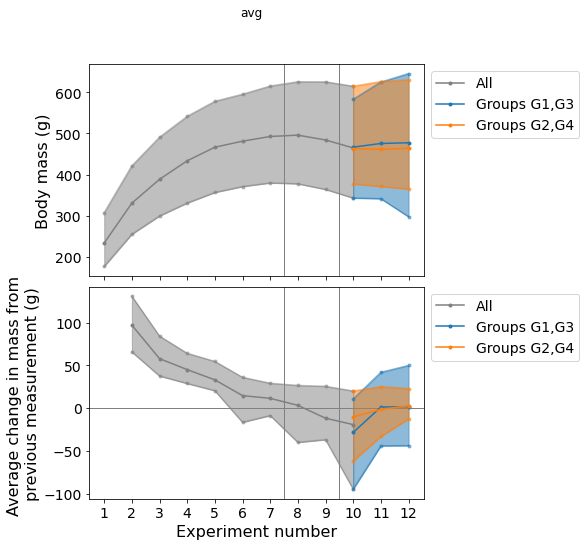

In [188]:

# df = rat.dfdata_to_dfpca(dfdata[(dfdata['Experiment']<=20)|( (dfdata['Experiment']>=24)&(dfdata['Experiment']<=26) )])
df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=12],dfdegree)
expnums = np.unique(df['Experiment'])
df.loc[df['Experiment']==11,'Heatmap'] = df.loc[df['Experiment']==12,'Heatmap'].values

uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[toplotmetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

tpx = np.arange(len(expnums)).astype(float)
# tpx[-3:] += 0.5
xticklabels = expnums

sel1 = groupnames_new.isin(['G1','G3'])
sel2 = groupnames_new.isin(['G2','G4'])
sel_all = np.tile(True,all_perratdatamat.shape[0])


bmchange='avg'

f,ax = plt.subplots(2,1,sharex=True)
f.set_size_inches(6,8)

sel = sel_all
clr = rat.snscolors[0]
for i in range(2):
    a=ax[i]
    if i==0:
        getq = lambda f: f(all_perratdatamat[sel,:,0],axis=0)
        a.set_ylabel('Body mass (g)',fontsize=16)
    elif i==1:
        if bmchange=='avg':
            getq = lambda f: np.concatenate(([np.nan],f(np.diff(all_perratdatamat[sel,:,0],axis=1),axis=0)))
        elif bmchange=='within':
            getq = lambda f: f(all_perratdatamat[sel,:,-1],axis=0)
        if bmchange=='avg':
            a.set_ylabel('Average change in mass from \nprevious measurement (g)',fontsize=16)
        else:
            a.set_ylabel('Change in body mass\nwithin experiment',fontsize=16)    
        a.axhline(0,c='gray',linewidth=1,zorder=-1)

    
    for sel,clr,label in zip([sel_all,sel1,sel2],['grey',rat.snscolors[0],rat.snscolors[1]],['All','Groups G1,G3','Groups G2,G4']):
        y = getq(np.nanmean)
        ystd = getq(np.nanstd)
        ymax = getq(np.nanmax)
        ymin = getq(np.nanmin)

        if np.all(sel):
            xsel = tpx<=9
        else:
            xsel = tpx>=9
        a.plot(tpx[xsel],y[xsel],c=clr,marker='.',label=label)
        a.fill_between(tpx[xsel],ymin[xsel],ymax[xsel],alpha=0.5,color=clr)
        a.plot(tpx[xsel],ymin[xsel],alpha=0.5,color=clr,marker='.')
        a.plot(tpx[xsel],ymax[xsel],alpha=0.5,color=clr,marker='.')


for a in ax:
    a.set_xticks(tpx)
    a.tick_params(labelsize=14)        
    [a.axvline(v,c='gray',linewidth=1,zorder=-1) for v in [6.5,8.5]]
    a.legend(bbox_to_anchor=(1,1),fontsize=14)

a=ax[-1]
a.set_xticklabels(xticklabels,fontsize=14)        
a.set_xlabel('Experiment number',fontsize=16)

plt.suptitle(bmchange)
plt.subplots_adjust(hspace=0.05)
plt.savefig(imagedir+'deltabodymass-pergroups.pdf')
plt.show()

## Correlation of body mass changes and social metrics

In [205]:
df = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']<=12],dfdegree)
expnums = np.unique(df['Experiment'])
p3startind = np.where(expnums==10)[0][0]

uids_pca = np.array(df['ID'])
uids_pca_int = np.zeros(len(uids_pca))
for i,uid in enumerate(rat.uids):
    uids_pca_int[uids_pca==uid] = i
expnums_pca = np.array(df['Experiment'])
datamat = np.array(df[toplotmetrics]).astype(float) 

all_perratdatamat = np.tile(np.nan,(len(rat.uids),len(expnums),datamat.shape[1]))
for i,uid in enumerate(rat.uids):
    all_perratdatamat[i] = datamat[uids_pca_int==i]
    if not np.all(np.diff(expnums_pca[uids_pca_int==i])>0):  # make sure it is in order, by exp number
        print('ERROR')

deltamass = all_perratdatamat[:,-1,0]-all_perratdatamat[:,-3,0]

p3norm = np.zeros((len(groupnames_new),3,len(toplotmetrics)))
for i in range(3):
    for g in rat.groupselnamesG:
        sel = groupnames_new==g
        for m in range(len(toplotmetrics)):
            vals = all_perratdatamat[sel,i+p3startind,m]
            p3norm[sel,i,m] = (vals-np.nanmean(vals))/np.nanstd(vals)

In [206]:
print('Period 3 expnums (check indices):',expnums[9:12])

Period 3 expnums (check indices): [10 11 12]


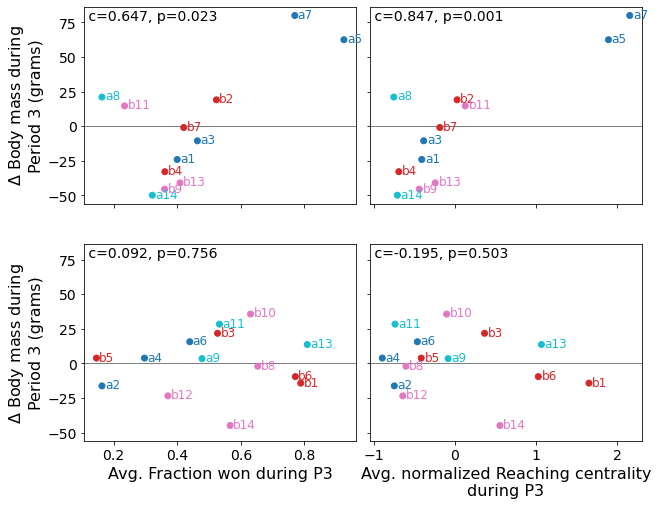

In [207]:
avg_pd3 = np.mean(all_perratdatamat[:,p3startind:p3startind+3,:],axis=1)
avg_pd3_norm = np.mean(p3norm,axis=1)

sel1 = groupnames_new.isin(['G1','G3'])
# remove rats a10 and 12, for consistency
# can output this to check and make sure its the right labels:  uidmasslabels['RBP'], uidmasslabels['OBP']
sel1['RBP'] = False
sel1['OBP'] = False
sel2 = groupnames_new.isin(['G2','G4'])

f,axx = plt.subplots(2,2,sharex='col',sharey=True)
f.set_size_inches(10,8)

for k, (sel,title) in enumerate(zip([sel1,sel2],['Groups G1 & G3','Groups G2 & G4'])):
    ax=axx[k]
    for i in range(2):
        a=ax[i]
        if i==0:
            x,y = avg_pd3[:,i+1],deltamass
            xoffset = 0.009
            xlabel = 'Avg. '+toplotmetrics[i+1]+' during P3'
        elif i==1:
            x,y = avg_pd3_norm[:,i+1],deltamass
            xoffset = 0.04
            xlabel = 'Avg. normalized '+toplotmetrics[i+1]+'\nduring P3'
        x,y = x[sel], y[sel]
        nnsel = np.logical_not(np.isnan(x)|np.isnan(y))
        corr,pvalue = scipy.stats.pearsonr(x[nnsel],y[nnsel])
        ## add filter to not show rat a10 (died), or a12 (removed)
        a.scatter(x,y,color=rat.groupcolors[groupnames_int.astype(int)][sel])
        labels = [x[1] for x in uidmasslabels.items()]
        for j,xtp,ytp in zip(np.where(sel)[0],x,y):
            a.annotate(labels[j], (xtp+xoffset, ytp-2),color=rat.groupcolors[groupnames_int[j]],fontsize=12)

        a.set_title(' c='+str(np.round(corr,3))+', p='+str(np.round(pvalue,3)),fontsize=14,y=0.9,loc='left')
        a.axhline(0,c='grey',zorder=-10,linewidth=1)
        a.tick_params(labelsize=14)
        if k==1:
            a.set_xlabel(xlabel,fontsize=16)


[a.set_ylabel('$\Delta$ Body mass during\nPeriod 3 (grams)',fontsize=16) for a in axx[:,0]]
plt.subplots_adjust(wspace=0.05)
plt.savefig(imagedir+'deltamass-Metrics.pdf')
plt.show()

## Corr of body mass at the beginning of Period 3, and social scores

9


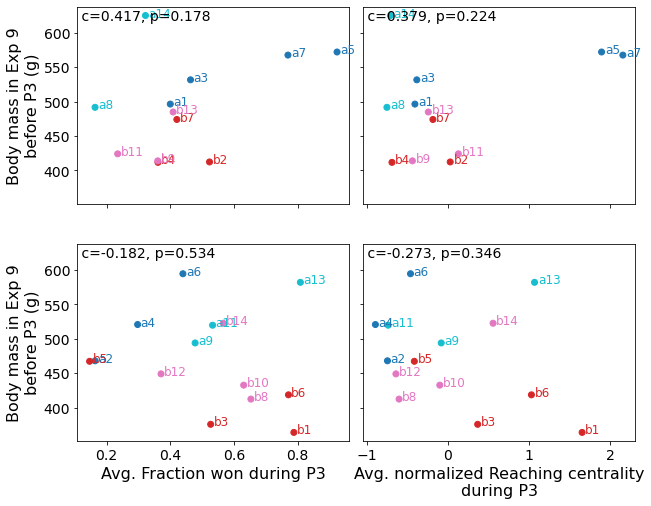

In [208]:
expind = -4
startingmass = all_perratdatamat[:,expind,0]
print(expnums[expind])
avg_pd3 = np.mean(all_perratdatamat[:,p3startind:p3startind+3,:],axis=1)
avg_pd3_norm = np.mean(p3norm,axis=1)

sel1 = groupnames_new.isin(['G1','G3'])
# remove rats a10 and 12, for consistency
# can output this to check and make sure its the right labels:  uidmasslabels['RBP'], uidmasslabels['OBP']
sel1['RBP'] = False
sel1['OBP'] = False
sel2 = groupnames_new.isin(['G2','G4'])

f,axx = plt.subplots(2,2,sharex='col',sharey=True)
f.set_size_inches(10,8)

for k, (sel,title) in enumerate(zip([sel1,sel2],['Groups G1 & G3','Groups G2 & G4'])):
    ax=axx[k]
    for i in range(2):
        a=ax[i]
        if i==0:
            x,y = avg_pd3[:,i+1],startingmass
            xoffset = 0.009
            xlabel = 'Avg. '+toplotmetrics[i+1]+' during P3'
        elif i==1:
            x,y = avg_pd3_norm[:,i+1],startingmass
            xoffset = 0.04
            xlabel = 'Avg. normalized '+toplotmetrics[i+1]+'\nduring P3'
        x,y = x[sel], y[sel]
        nnsel = np.logical_not(np.isnan(x)|np.isnan(y))
        corr,pvalue = scipy.stats.pearsonr(x[nnsel],y[nnsel])
        ## add filter to not show rat a10 (died), or a12 (removed)
        a.scatter(x,y,color=rat.groupcolors[groupnames_int.astype(int)][sel])
        labels = [x[1] for x in uidmasslabels.items()]
        for j,xtp,ytp in zip(np.where(sel)[0],x,y):
            a.annotate(labels[j], (xtp+xoffset, ytp-2),color=rat.groupcolors[groupnames_int[j]],fontsize=12)

        a.set_title(' c='+str(np.round(corr,3))+', p='+str(np.round(pvalue,3)),fontsize=14,y=0.9,loc='left')
        # a.axhline(0,c='grey',zorder=-10,linewidth=1)
        a.tick_params(labelsize=14)
        if k==1:
            a.set_xlabel(xlabel,fontsize=16)


[a.set_ylabel('Body mass in Exp '+str(expnums[expind])+'\nbefore P3 (g)',fontsize=16) for a in axx[:,0]]
plt.subplots_adjust(wspace=0.05)
plt.savefig(imagedir+'Exp9mass-Metrics.pdf')
plt.show()

## which rat lost the most weight?


In [195]:
# what rat lost the most weight?
min_by_exp = getq(np.nanargmin)[1:]
min_vals = getq(np.nanmin)[1:]
min_names = [uidmasslabels[rat.uids[int(m)]] for m in min_by_exp]
pd.DataFrame([min_names,min_by_exp,min_vals],columns=np.arange(2,13))

2     3     4     5    6    7     8     9     10    11    12
0   a13   a11    a6    a6   a7   a1    a4    a4    a4    a8    a5
1  13.0   9.0   6.0   6.0  2.0  1.0   4.0   4.0   4.0  12.0   0.0
2  65.7  42.3  31.5  25.7 -2.5 -5.5 -29.7 -36.9 -61.8 -33.2 -12.7

# (Fig S) Calculate composite scores from Individual and Paired tests

In [11]:
# save the scores in this, so can compare after
scores_to_compare = pd.DataFrame(index=allscores.index)

## Boldness

In [12]:
allscores.head()

BWB-All Frames  BWB-Black  BWB-White  BWB-Both  BWB-None  \
ID                                                              
BGP            7500       6860        359       281         0   
BOP            7500       5889       1462       149         0   
GBP            7500       5822       1072       578        28   
GOB            7500       5977        545       978         0   
GOP            7500       3590       2910      1000         0   

     ElevX-All Frames  ElevX-Closed  ElevX-Open  ElevX-Both  ElevX-None  \
ID                                                                        
BGP              7500          2738        3704         193         865   
BOP              7500          5633        1566         108         193   
GBP              7500          2286        4167         435         612   
GOB              7500           604        5344          37        1515   
GOP              7500             0        7500           0           0   

     Canopy-All Frames  Canopy-OUT  Canopy-Under  
ID                                                
BGP               7500        3607          3893  
BOP               7500        2738          4762  
GBP               3960        3466           494  
GOB               7500        7220           280  
GOP               7500        7094           406

In [13]:
tests = ['BWB','ElevX','Canopy']
 # create normalized values: fraction
allscores_norm = pd.DataFrame(index=allscores.index)
for test in tests:
    testmetrics = allscores.columns[[(test in c)&(not('Frames' in c)) for c in allscores.columns]]
    frames = allscores[test+'-All Frames']
    for m in testmetrics:
        allscores_norm[m+'-frac'] = allscores[m]/frames
allscores_norm.head()

BWB-Black-frac  BWB-White-frac  BWB-Both-frac  BWB-None-frac  \
ID                                                                  
BGP        0.914667        0.047867       0.037467       0.000000   
BOP        0.785200        0.194933       0.019867       0.000000   
GBP        0.776267        0.142933       0.077067       0.003733   
GOB        0.796933        0.072667       0.130400       0.000000   
GOP        0.478667        0.388000       0.133333       0.000000   

     ElevX-Closed-frac  ElevX-Open-frac  ElevX-Both-frac  ElevX-None-frac  \
ID                                                                          
BGP           0.365067         0.493867         0.025733         0.115333   
BOP           0.751067         0.208800         0.014400         0.025733   
GBP           0.304800         0.555600         0.058000         0.081600   
GOB           0.080533         0.712533         0.004933         0.202000   
GOP           0.000000         1.000000         0.000000         0.000000   

     Canopy-OUT-frac  Canopy-Under-frac  
ID                                       
BGP         0.480933           0.519067  
BOP         0.365067           0.634933  
GBP         0.875253           0.124747  
GOB         0.962667           0.037333  
GOP         0.945867           0.054133

In [14]:
# do this instead to use only 8, removing NoneBW and NoneEL
pcametrics = ['BWB-Black-frac', 'BWB-White-frac', 'BWB-Both-frac',
       'ElevX-Closed-frac', 'ElevX-Open-frac', 'ElevX-Both-frac',
        'Canopy-OUT-frac', 'Canopy-Under-frac']
# values to use for PCA
pcamat = allscores_norm.loc[:,pcametrics].values

In [15]:
pcametrics = [c[0:-5] for c in pcametrics]
pcametrics

['BWB-Black',
 'BWB-White',
 'BWB-Both',
 'ElevX-Closed',
 'ElevX-Open',
 'ElevX-Both',
 'Canopy-OUT',
 'Canopy-Under']

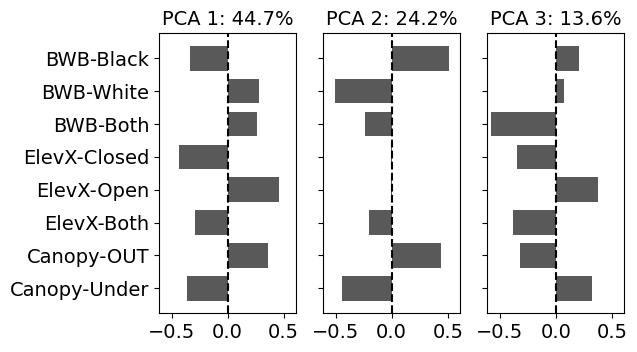

In [37]:
## PCA
pcamat = (pcamat-np.mean(pcamat,axis=0))/np.std(pcamat,axis=0)
pca = PCA(n_components=pcamat.shape[1]).fit(pcamat)
vh = pca.components_
u = pca.transform(pcamat)
pcavarmeas = pca.explained_variance_ratio_


numev_toshow = 3
f,ax = plt.subplots(1,numev_toshow,sharex=True,sharey=True)
scalesize=1
f.set_size_inches(2*numev_toshow*scalesize,5/11*len(pcametrics)*scalesize)
rat.pcacomponentplots(ax,vh[:numev_toshow],pcametrics)
for j in range(numev_toshow):
    a = ax[j]
    a.set_title('PCA '+str(j+1)+': '+str(round(pcavarmeas[j]*100,1))+'%',fontsize=14)
plt.savefig(imagedir+'pca-bold-1.pdf')
plt.show()

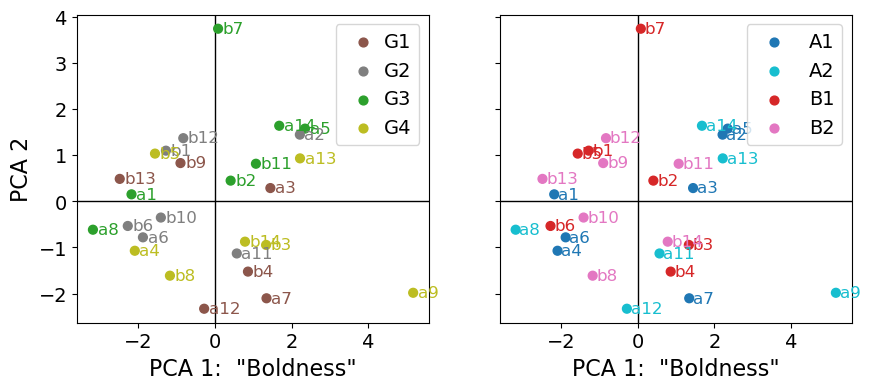

In [212]:
## plot 2D embedding with labels
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
f.set_size_inches(10,4)
pointsize=40
labels = dfuidlabels.loc[allscores_norm.index,'masslabel'].values

a=ax[1]
coloroffset=0
rat.plot_tsne_withcolors(a,u[:,0:2],dfuidlabels.loc[allscores_norm.index,'Group'],'',labels=labels,labeloffset=(0.1,-0.1),coloroffset=coloroffset,
                         colortype='cat',s=pointsize,alphaval=1,qmin=0,qmax=1,snscolors=rat.groupcolors)
# legend hack for markers
xlim, ylim = a.get_xlim(), a.get_ylim()
for i,g in enumerate(rat.groupselnames):
    a.scatter([-100],[-100],color=rat.groupcolors[i+coloroffset],s=pointsize,label=g)
a.legend(fontsize=14)
a.set_xlim(xlim)
a.set_ylim(ylim)

a=ax[0]
coloroffset=4
rat.plot_tsne_withcolors(a,u[:,0:2],dfuidlabels.loc[allscores_norm.index,'GroupG'],'',labels=labels,labeloffset=(0.12,-0.1),coloroffset=coloroffset,
                         colortype='cat',s=pointsize,alphaval=1,qmin=0,qmax=1,snscolors=rat.groupcolors)
# legend hack for markers
xlim, ylim = a.get_xlim(), a.get_ylim()
for i,g in enumerate(rat.groupselnamesG):
    a.scatter([-100],[-100],color=rat.groupcolors[i+coloroffset],s=pointsize,label=g)
a.legend(fontsize=14,handletextpad=0.1)
a.set_xlim(xlim)
a.set_ylim(ylim)

for a in ax:
    a.axhline(0,color='k',zorder=-10,linewidth=1)
    a.axvline(0,color='k',zorder=-10,linewidth=1)
    a.tick_params(labelsize=14)
    a.set_xlabel('PCA 1:  "Boldness"',fontsize=16)
ax[0].set_ylabel('PCA 2',fontsize=16)
plt.savefig(imagedir+'pca-bold-2.pdf')
plt.show()

In [213]:
scores_to_compare['Boldness'] = u[:,0]

In [214]:
# addition ones to save:
# Black&White Box: White/(Black+White)
whitefrac = allscores_norm['BWB-White-frac']/(allscores_norm['BWB-White-frac']+allscores_norm['BWB-Black-frac'])
# Elevated cross: Open/(Open+Closed)
openfrac = allscores_norm['ElevX-Open-frac']/(allscores_norm['ElevX-Open-frac']+allscores_norm['ElevX-Closed-frac'])
# Canopy: Out/(Out+Under)
outfrac = allscores_norm['Canopy-OUT-frac']/(allscores_norm['Canopy-OUT-frac']+allscores_norm['Canopy-Under-frac'])

scores_to_compare['BWB-whitefrac'] = whitefrac
scores_to_compare['ElevX-openfrac'] = openfrac
scores_to_compare['Canopy-outfrac'] = outfrac

# Pairwise tests:  Social and Self- interest

In [215]:
pairedtests.head()

rat_group_N  freq_standup_unfam1  freq_standup_unfam2  \
rat_ID                                                          
BGP               2                   28                   15   
BOP               2                   25                   32   
GBP               3                   12                   43   
GOB               3                   18                   22   
GOP               4                   18                    7   

        freq_standup_fam1  freq_standup_fam2  freq_standup_fam3  \
rat_ID                                                            
BGP                    26                 22                 36   
BOP                    37                 31                 16   
GBP                    18                 37                 15   
GOB                    16                 10                 34   
GOP                    13                  7                 10   

       freq_standup_fam4  freq_stepon_unfam1  freq_stepon_unfam2  \
rat_ID                                                             
BGP                   11                  23                   4   
BOP                   32                   6                   8   
GBP                   29                   0                   6   
GOB                   44                   6                  10   
GOP                    8                   6                   2   

        freq_stepon_fam1  ...  perc_selfgrooming_fam1  perc_selfgrooming_fam2  \
rat_ID                    ...                                                   
BGP                    6  ...                   13.87                   15.77   
BOP                    5  ...                   25.66                   19.17   
GBP                    1  ...                    6.42                   15.40   
GOB                    0  ...                   59.67                   46.50   
GOP                    2  ...                   13.58                    7.46   

       perc_selfgrooming_fam3  perc_selfgrooming_fam4  perc_stepon_unfam1  \
rat_ID                                                                      
BGP                     23.12                   11.94                7.95   
BOP                     12.21                   23.52                2.31   
GBP                     23.74                   21.08                0.00   
GOB                     13.04                   20.13                2.90   
GOP                      1.07                   21.66                2.18   

        perc_stepon_unfam2  perc_stepon_fam1  perc_stepon_fam2  \
rat_ID                                                           
BGP                   0.90              1.45              0.00   
BOP                   3.85              1.42              0.43   
GBP                   2.19              0.11              0.21   
GOB                   4.12              0.00              0.00   
GOP                   3.58              0.53              0.34   

       perc_stepon_fam3  perc_stepon_fam4  
rat_ID                                     
BGP                0.03               .31  
BOP                0.00               .75  
GBP                0.05                .1  
GOB                0.98              2.06  
GOP                0.60               .24  

[5 rows x 79 columns]

## Unfamiliar rat

In [216]:
pcametrics = ['freq_sniff_genit_unfam1', 'freq_sniff_body_unfam1', 'freq_standup_unfam1', 'freq_stepon_unfam1', 'freq_mate_unfam1', 'freq_fight_unfam1', 'perc_expl_unfam1', 'perc_selfgrooming_unfam1']
pcamat = pairedtests[pcametrics].copy().values
colmean, colstd = np.mean(pcamat,axis=0), np.std(pcamat,axis=0)

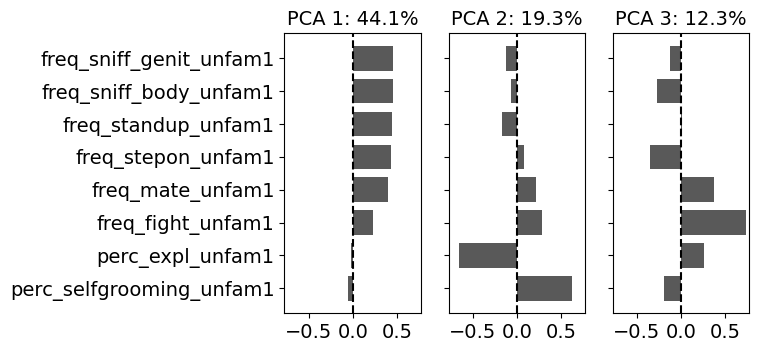

In [217]:
## PCA - define and fit here, to then use below
pcamat = (pcamat-colmean)/colstd
pca = PCA(n_components=pcamat.shape[1]).fit(pcamat)
vh = pca.components_
u = pca.transform(pcamat)
pcavarmeas = pca.explained_variance_ratio_


numev_toshow = 3
f,ax = plt.subplots(1,numev_toshow,sharex=True,sharey=True)
scalesize=1
f.set_size_inches(2*numev_toshow*scalesize,5/11*len(pcametrics)*scalesize)
rat.pcacomponentplots(ax,vh[:numev_toshow],pcametrics)
for j in range(numev_toshow):
    a = ax[j]
    a.set_title('PCA '+str(j+1)+': '+str(round(pcavarmeas[j]*100,1))+'%',fontsize=14)
plt.savefig(imagedir+'pca-unfam-vh.pdf')
plt.show()

In [218]:
scores_to_compare['Unfamiliar-Social interest'] = u[:,0]
scores_to_compare['Unfamiliar-Self grooming'] = u[:,1]
scores_to_compare.head()

Boldness  BWB-whitefrac  ElevX-openfrac  Canopy-outfrac  \
ID                                                             
BGP -0.826144       0.049730        0.574977        0.480933   
BOP -1.410980       0.198885        0.217530        0.365067   
GBP  1.068480       0.155498        0.645746        0.875253   
GOB  2.346873       0.083563        0.898453        0.962667   
GOP  5.168235       0.447692        1.000000        0.945867   

     Unfamiliar-Social interest  Unfamiliar-Self grooming  
ID                                                         
BGP                    2.445688                  0.145650  
BOP                   -0.651190                 -0.595714  
GBP                   -2.536990                  0.674717  
GOB                   -1.370983                 -0.076821  
GOP                   -0.153464                  0.039228

## Familiar rat

In [219]:
# use same metrics, but for familiar rat instead
pcametrics_familiar = [x[0:-6]+'fam1' for x in pcametrics]
pcamat = pairedtests[pcametrics_familiar].copy().values

# normalized by the unfam rat values, so can use the same projection
pcamat = (pcamat-colmean)/colstd

u = pca.transform(pcamat)

In [220]:
scores_to_compare['Familiar-Social interest'] = u[:,0]
scores_to_compare['Familiar-Self grooming'] = u[:,1]
scores_to_compare.head()

Boldness  BWB-whitefrac  ElevX-openfrac  Canopy-outfrac  \
ID                                                             
BGP -0.826144       0.049730        0.574977        0.480933   
BOP -1.410980       0.198885        0.217530        0.365067   
GBP  1.068480       0.155498        0.645746        0.875253   
GOB  2.346873       0.083563        0.898453        0.962667   
GOP  5.168235       0.447692        1.000000        0.945867   

     Unfamiliar-Social interest  Unfamiliar-Self grooming  \
ID                                                          
BGP                    2.445688                  0.145650   
BOP                   -0.651190                 -0.595714   
GBP                   -2.536990                  0.674717   
GOB                   -1.370983                 -0.076821   
GOP                   -0.153464                  0.039228   

     Familiar-Social interest  Familiar-Self grooming  
ID                                                     
BGP                 -0.931243                0.335352  
BOP                 -0.730471                0.467839  
GBP                 -1.999695               -0.120665  
GOB                 -2.018257                3.380600  
GOP                 -1.501240                0.893142

## Unfamiliar - repeated

In [221]:
# use same metrics, but for the second unfamiliar rat tested
pcametrics_unfam2 = [x[0:-6]+'unfam2' for x in pcametrics]
pcamat = pairedtests[pcametrics_unfam2].copy().values

# normalized by the unfam rat values, so can use the same projection
pcamat = (pcamat-colmean)/colstd

u = pca.transform(pcamat)

In [222]:
scores_to_compare['Unfamiliar2-Social interest'] = u[:,0]
scores_to_compare['Unfamiliar2-Self grooming'] = u[:,1]
scores_to_compare.head()

Boldness  BWB-whitefrac  ElevX-openfrac  Canopy-outfrac  \
ID                                                             
BGP -0.826144       0.049730        0.574977        0.480933   
BOP -1.410980       0.198885        0.217530        0.365067   
GBP  1.068480       0.155498        0.645746        0.875253   
GOB  2.346873       0.083563        0.898453        0.962667   
GOP  5.168235       0.447692        1.000000        0.945867   

     Unfamiliar-Social interest  Unfamiliar-Self grooming  \
ID                                                          
BGP                    2.445688                  0.145650   
BOP                   -0.651190                 -0.595714   
GBP                   -2.536990                  0.674717   
GOB                   -1.370983                 -0.076821   
GOP                   -0.153464                  0.039228   

     Familiar-Social interest  Familiar-Self grooming  \
ID                                                      
BGP                 -0.931243                0.335352   
BOP                 -0.730471                0.467839   
GBP                 -1.999695               -0.120665   
GOB                 -2.018257                3.380600   
GOP                 -1.501240                0.893142   

     Unfamiliar2-Social interest  Unfamiliar2-Self grooming  
ID                                                           
BGP                    -1.172035                   0.227558  
BOP                    -0.477942                   0.243811  
GBP                    -0.328767                  -0.963170  
GOB                     0.134909                  -0.981417  
GOP                    -2.200093                   0.118918

## Compare tests and embeddings

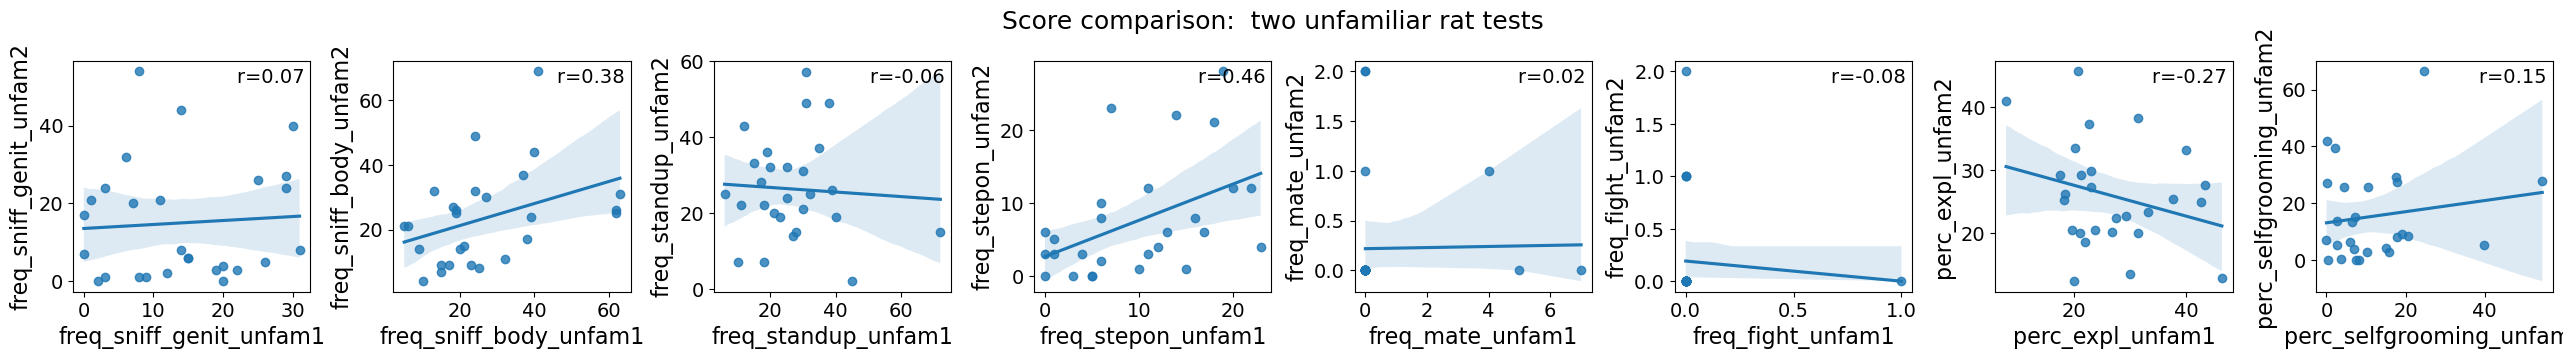

In [223]:
# compare the two times, for metrics consistency
f,ax=plt.subplots(1,len(pcametrics))
f.set_size_inches(4*len(pcametrics),3)
for i,(m,m2) in enumerate(zip(pcametrics,pcametrics_unfam2)):
    x=pairedtests[m]
    y=pairedtests[m2]
    a=ax[i]
    sns.regplot(x=x,y=y,ax=a)
    corr = scipy.stats.pearsonr(x,y)[0]
    a.set_title('r='+str(np.round(corr,2))+' ',fontsize=14,y=0.87,loc='right')
    a.set_xlabel(m,fontsize=16)
    a.set_ylabel(m2,fontsize=16)
    a.tick_params(labelsize=14)    
plt.subplots_adjust(wspace=0.35)
plt.suptitle('Score comparison:  two unfamiliar rat tests',fontsize=18,y=1.05)
plt.savefig(imagedir+'unfam1-unfam2.pdf')
plt.show()

In [224]:
scores_to_compare.columns

Index(['Boldness', 'BWB-whitefrac', 'ElevX-openfrac', 'Canopy-outfrac',
       'Unfamiliar-Social interest', 'Unfamiliar-Self grooming',
       'Familiar-Social interest', 'Familiar-Self grooming',
       'Unfamiliar2-Social interest', 'Unfamiliar2-Self grooming'],
      dtype='object')

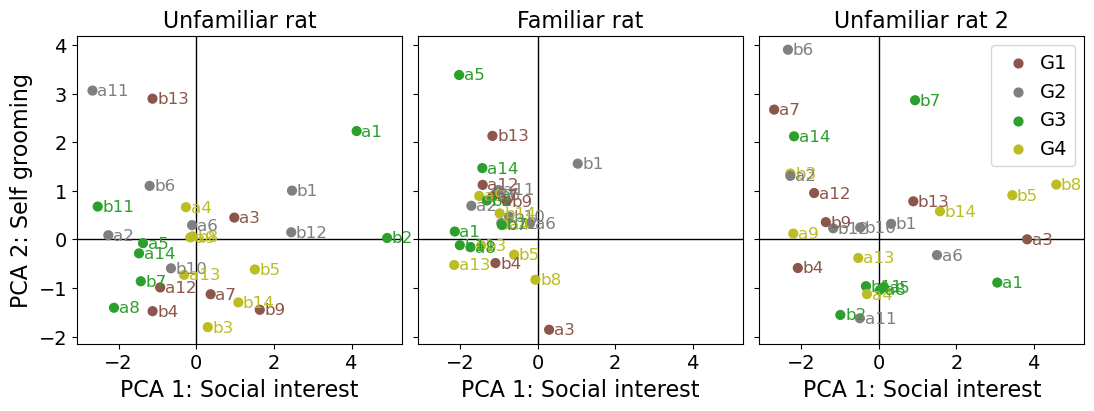

In [225]:
## plot 2D embedding with - all pairwise tests
f,ax = plt.subplots(1,3,sharex=True,sharey=True)
f.set_size_inches(13,4)
pointsize=40
labels = dfuidlabels.loc[pairedtests.index,'masslabel'].values
coloroffset=4

## Unfamiliar (main one)
a=ax[0]
toshow = ['Unfamiliar-Social interest','Unfamiliar-Self grooming']
rat.plot_tsne_withcolors(a,scores_to_compare[toshow].values,dfuidlabels.loc[pairedtests.index,'GroupG'],'',labels=labels,labeloffset=(0.12,-0.1),coloroffset=coloroffset,
                         colortype='cat',s=pointsize,alphaval=1,qmin=0,qmax=1,snscolors=rat.groupcolors)
a.set_title('Unfamiliar rat',fontsize=16)

## Familiar
a=ax[1]
toshow = ['Familiar-Social interest','Familiar-Self grooming']
rat.plot_tsne_withcolors(a,scores_to_compare[toshow].values,dfuidlabels.loc[pairedtests.index,'GroupG'],'',labels=labels,labeloffset=(0.12,-0.1),coloroffset=coloroffset,
                         colortype='cat',s=pointsize,alphaval=1,qmin=0,qmax=1,snscolors=rat.groupcolors)
a.set_title('Familiar rat',fontsize=16)

## Unfamiliar 2
a=ax[2]
toshow = ['Unfamiliar2-Social interest','Unfamiliar2-Self grooming']
rat.plot_tsne_withcolors(a,scores_to_compare[toshow].values,dfuidlabels.loc[pairedtests.index,'GroupG'],'',labels=labels,labeloffset=(0.12,-0.1),coloroffset=coloroffset,
                         colortype='cat',s=pointsize,alphaval=1,qmin=0,qmax=1,snscolors=rat.groupcolors)
a.set_title('Unfamiliar rat 2',fontsize=16)

a=ax[-1]
# legend hack for markers
xlim, ylim = a.get_xlim(), a.get_ylim()
for i,g in enumerate(rat.groupselnamesG):
    a.scatter([-100],[-100],color=rat.groupcolors[i+coloroffset],s=pointsize,label=g)
a.legend(fontsize=14,handletextpad=0.1)
a.set_xlim(xlim)
a.set_ylim(ylim)

for a in ax:
    a.axhline(0,color='k',zorder=-10,linewidth=1)
    a.axvline(0,color='k',zorder=-10,linewidth=1)
    a.tick_params(labelsize=14)
    a.set_xlabel('PCA 1: Social interest',fontsize=16)
ax[0].set_ylabel('PCA 2: Self grooming',fontsize=16)
plt.subplots_adjust(wspace=0.05)
plt.savefig(imagedir+'pca-all.pdf')
plt.show()

# (Fig 8) Metrics compared to assays

In [169]:
scores_to_compare.head()

Boldness  BWB-whitefrac  ElevX-openfrac  Canopy-outfrac  \
ID                                                             
BGP -0.826144       0.049730        0.574977        0.480933   
BOP -1.410980       0.198885        0.217530        0.365067   
GBP  1.068480       0.155498        0.645746        0.875253   
GOB  2.346873       0.083563        0.898453        0.962667   
GOP  5.168235       0.447692        1.000000        0.945867   

     Unfamiliar-Social interest  Unfamiliar-Self grooming  \
ID                                                          
BGP                    2.445688                  0.145650   
BOP                   -0.651190                 -0.595714   
GBP                   -2.536990                  0.674717   
GOB                   -1.370983                 -0.076821   
GOP                   -0.153464                  0.039228   

     Familiar-Social interest  Familiar-Self grooming  \
ID                                                      
BGP                 -0.931243                0.335352   
BOP                 -0.730471                0.467839   
GBP                 -1.999695               -0.120665   
GOB                 -2.018257                3.380600   
GOP                 -1.501240                0.893142   

     Unfamiliar2-Social interest  Unfamiliar2-Self grooming  
ID                                                           
BGP                    -1.172035                   0.227558  
BOP                    -0.477942                   0.243811  
GBP                    -0.328767                  -0.963170  
GOB                     0.134909                  -0.981417  
GOP                    -2.200093                   0.118918

## all-to-all score comparisons

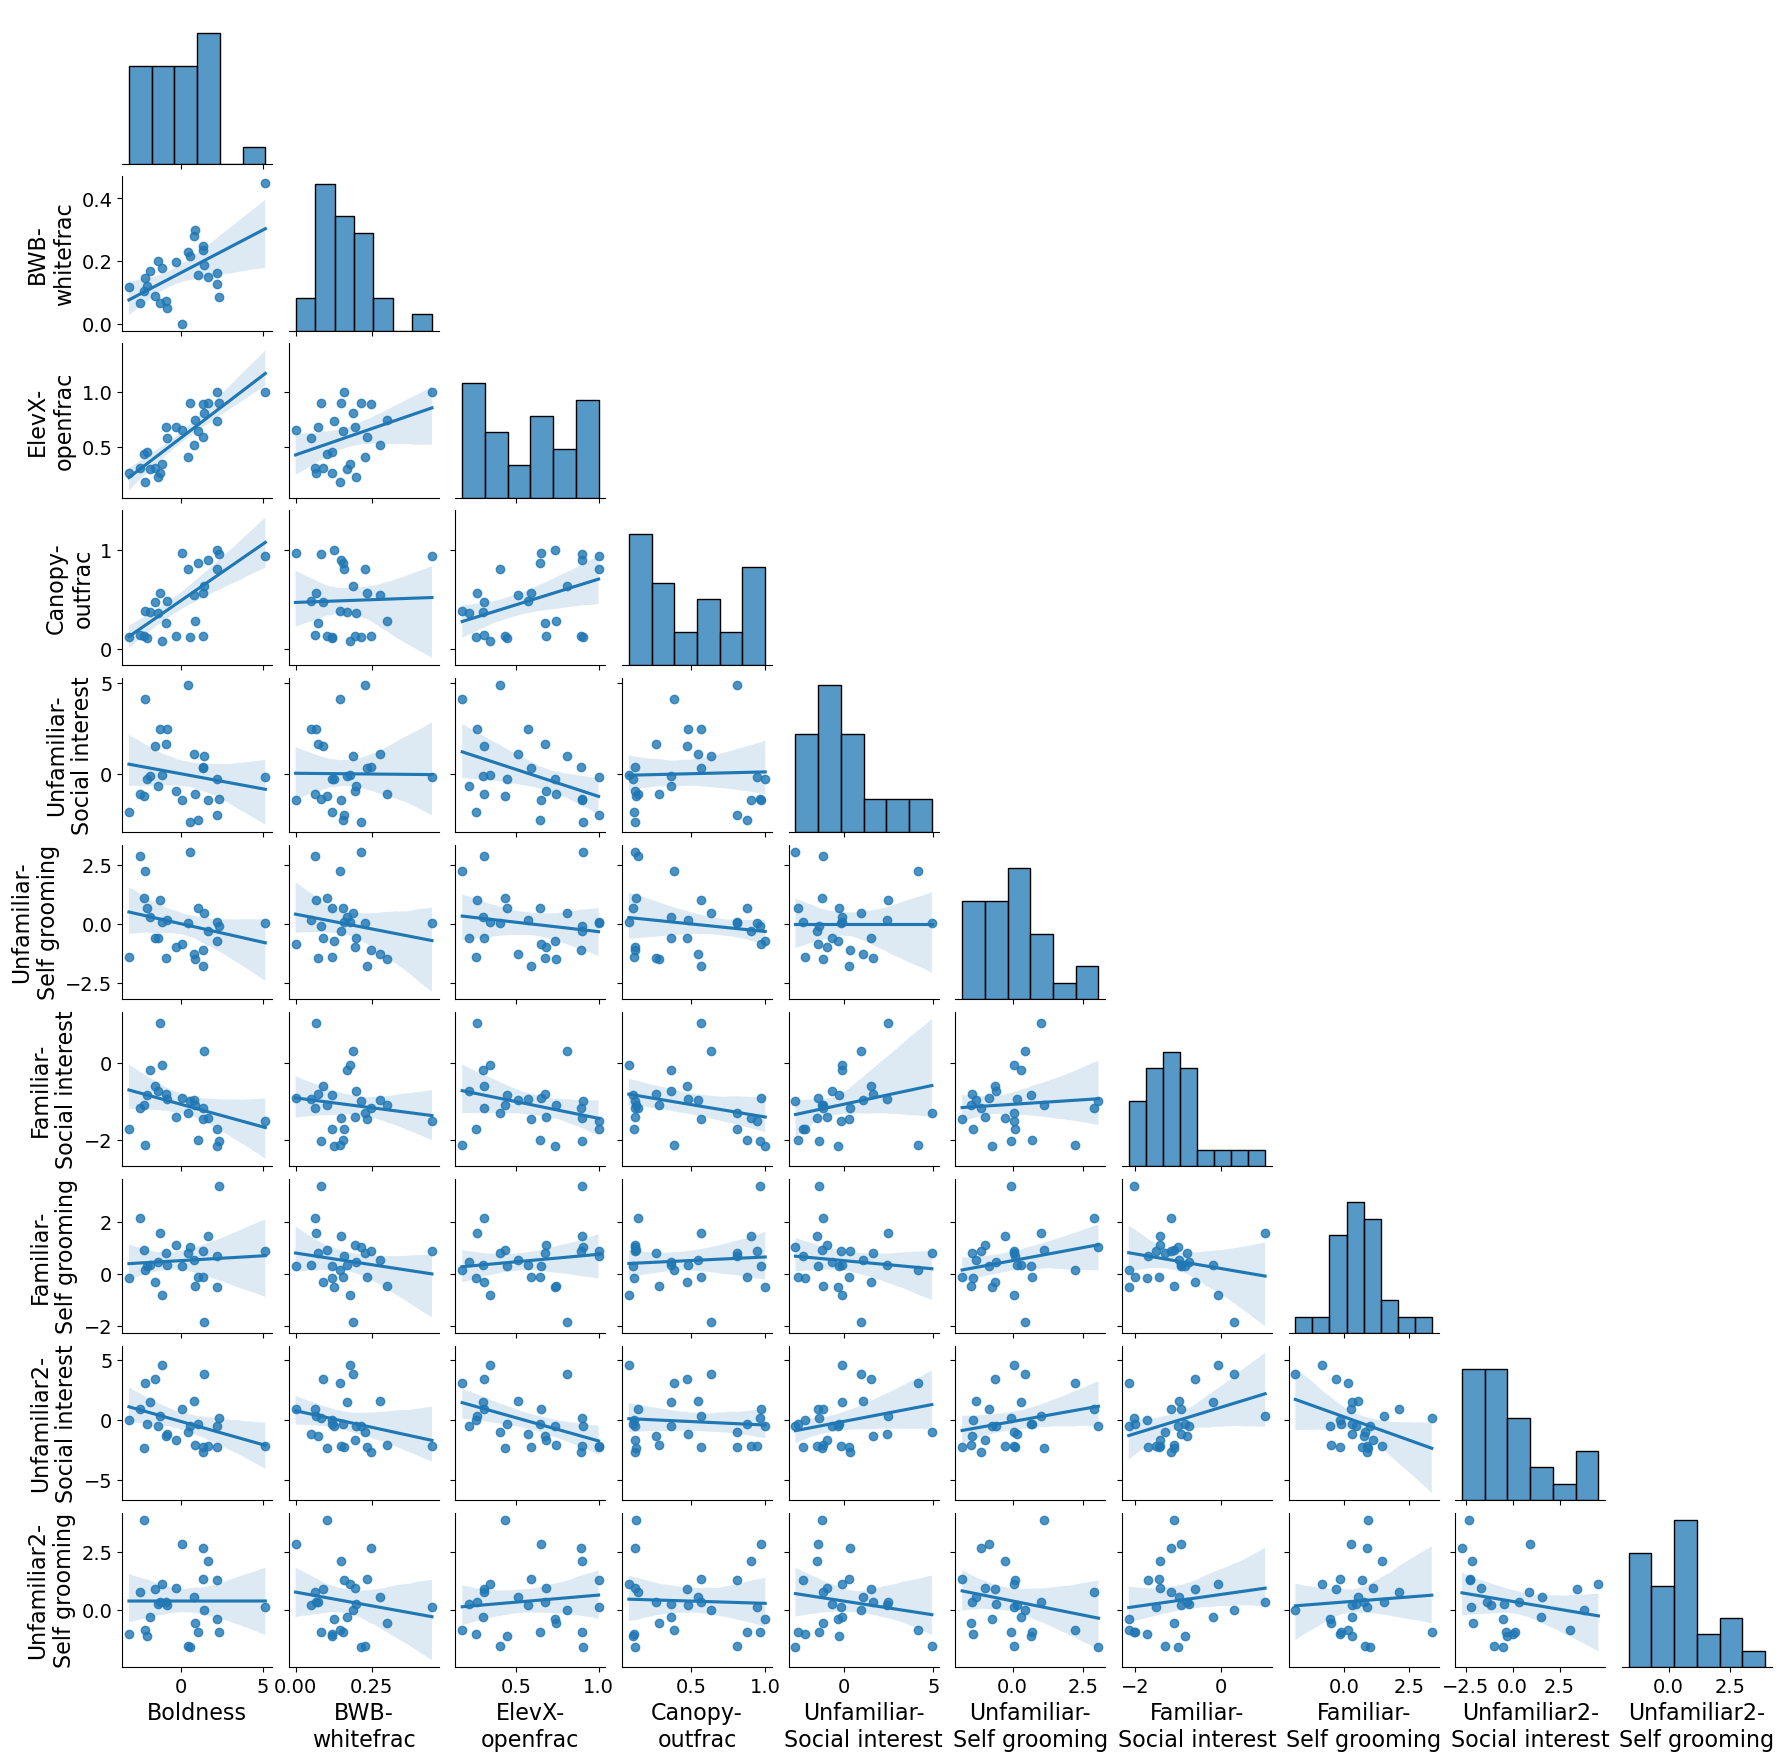

In [234]:
# with sns.plotting_context(rc={"axes.labelsize":16,'xtick.labelsize':14,'ytick.labelsize':14}):
g = sns.pairplot(scores_to_compare,kind='reg',corner=True,height=1.75)
for a in g.axes.flatten():
    if not(a==None):
        a.tick_params(labelsize=14)
for ay,ax,label in zip(g.axes[:,0],g.axes[-1,:],scores_to_compare.columns):
    lbl = label.replace('-','-\n')
    ay.set_ylabel(lbl,fontsize=16)
    ax.set_xlabel(lbl,fontsize=16)
plt.savefig(imagedir+'score-score.pdf')
plt.show()

### Raster plot showing correlations between scores

In [171]:
scorenames = scores_to_compare.columns

In [172]:
corr_scores = np.tile(np.nan,(len(scorenames),len(scorenames)))
pvalues = corr_scores.copy()

for i,m1 in enumerate(scorenames):
    for j,m2 in enumerate(scorenames):
        if not(i==j):
            x,y = scores_to_compare[m1].astype(float), scores_to_compare[m2].astype(float)
            sel = np.logical_not(np.isnan(x)|np.isnan(y))
            if np.sum(sel)>2:
                corr,pvalue = scipy.stats.pearsonr(x[sel],y[sel])
                corr_scores[i,j] = corr
                pvalues[i,j] = pvalue


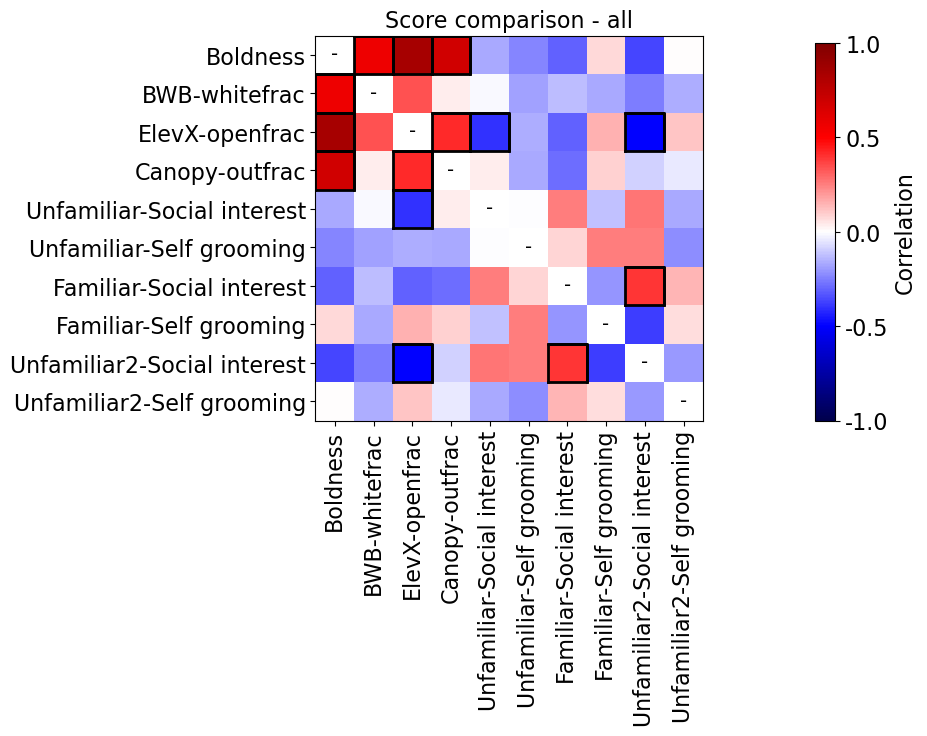

In [231]:
f,ax = plt.subplots(1,1,sharex=True,sharey=True)
ax=[ax]
f.set_size_inches(5,5)
tpx = np.arange(len(scorenames))
tpy = np.flip(np.arange(len(scorenames)))

a=ax[0]
raster = a.pcolormesh(tpx,tpy,corr_scores.T,cmap='seismic',vmin=-1,vmax=1)
a.set_title('Score comparison - all',fontsize=16)
# highlight significant p value scores
sigvalues = np.where(pvalues<0.05)
for sx, sy in zip(sigvalues[0],sigvalues[1]):
    x0,x1 = tpx[sx]-0.5, tpx[sx]+0.5
    y0,y1 = tpy[sy]-0.5, tpy[sy]+0.5
    a.plot([[x0,x1],[x1,x1],[x1,x0],[x0,x0]],[[y0,y0],[y0,y1],[y1,y1],[y1,y0]],
        c='k',linewidth=2,zorder=10)
    
# tick labels
ax[0].set_xticks(tpx)
[a.set_xticklabels(scorenames,fontsize=16,rotation=90) for a in ax]
ax[0].set_yticks(tpy)
ax[0].set_yticklabels(scorenames,fontsize=16)
# legend as colorbar
a=ax[-1]
position=f.add_axes([a._position.bounds[0]+1,a._position.bounds[1]+0.0,.04,0.755])
cbar=plt.colorbar(raster,ax=ax,cax=position,orientation='vertical')    
cbar.set_label('Correlation',fontsize=16)
ticks = np.arange(-1,1.1,0.5)
cbar.set_ticks(ticks)
ticks=[str(t) for t in ticks]
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=16)   

[a.annotate('-',(i-0.095,len(scorenames)-i-1-0.12),fontsize=14) for i in range(len(scorenames))]

plt.savefig(imagedir+'ScoreComparison.pdf',bbox_inches='tight')
plt.show()

## Main text comparisons

### Strain- and group-specific comparisons

In [72]:
indivtestmetrics = ['Boldness','Unfamiliar-Social interest','Unfamiliar-Self grooming']
indivtestmetrics_displaynames = ['Boldness','Social interest','Self grooming']

In [73]:
dfjoined = scores_to_compare.join(dfuidlabels)

In [74]:
# normalize each score
for m in indivtestmetrics:
    v=dfjoined[m]
    dfjoined[m] = (v-np.nanmean(v))/np.std(v)
dfjoined.head()

Boldness  BWB-whitefrac  ElevX-openfrac  Canopy-outfrac  \
ID                                                             
BGP -0.436712       0.049730        0.574977        0.480933   
BOP -0.745865       0.198885        0.217530        0.365067   
GBP  0.564814       0.155498        0.645746        0.875253   
GOB  1.240591       0.083563        0.898453        0.962667   
GOP  2.732005       0.447692        1.000000        0.945867   

     Unfamiliar-Social interest  Unfamiliar-Self grooming  \
ID                                                          
BGP                    1.301769                  0.117222   
BOP                   -0.346610                 -0.479444   
GBP                   -1.350367                  0.543028   
GOB                   -0.729735                 -0.061828   
GOP                   -0.081684                  0.031572   

     Familiar-Social interest  Familiar-Self grooming  \
ID                                                      
BGP                 -0.931243                0.335352   
BOP                 -0.730471                0.467839   
GBP                 -1.999695               -0.120665   
GOB                 -2.018257                3.380600   
GOP                 -1.501240                0.893142   

     Unfamiliar2-Social interest  Unfamiliar2-Self grooming masslabel  \
ID                                                                      
BGP                    -1.172035                   0.227558       b12   
BOP                    -0.477942                   0.243811       b10   
GBP                    -0.328767                  -0.963170       b11   
GOB                     0.134909                  -0.981417        a5   
GOP                    -2.200093                   0.118918        a9   

     GroupMassRank-Exp7 Group GroupG P3gc_ind P1gc_ind linestyle  
ID                                                                
BGP                 5.0    B2     G2        5        3        --  
BOP                 3.0    B2     G2        5        3         -  
GBP                 4.0    B2     G3        6        3         -  
GOB                 5.0    A1     G3        6        0        --  
GOP                 2.0    A2     G4        7        1         -

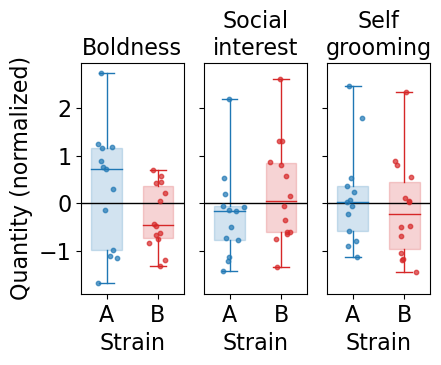

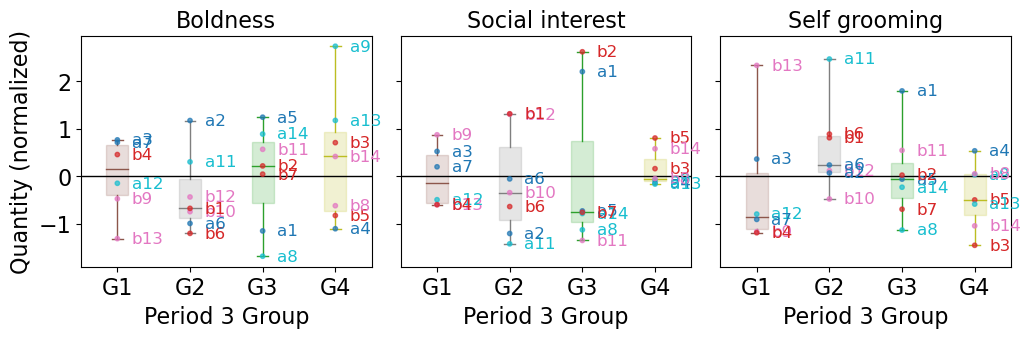

In [77]:
numq=3
# use the same data, but make different selectors to plot
tpdata = dfjoined[indivtestmetrics].values.T
sel = np.logical_not(np.any(np.isnan(tpdata),axis=0))
tpdata = tpdata[:,sel]

## Strain
f,ax = plt.subplots(1,numq,sharex=False,sharey=True)
f.set_size_inches(1.5*numq,3)
tpcats = np.array([t[0] for t in dfjoined['Group'].values])[sel]
rat.quantitydists(tpcats,tpdata,[x.replace(' ','\n') for x in indivtestmetrics_displaynames],coloroffset=100,
              color=rat.groupcolors[[0,2]],f=f,ax=ax)
ax[0].set_ylabel('Quantity (normalized)',fontsize=16)
[a.set_xlabel('Strain',fontsize=16) for a in ax]
plt.subplots_adjust(wspace=0.2)
plt.savefig(imagedir+'indivtests-strain.pdf')
plt.show()

## Original group - not relevant
# tpcats = dfjoined['Group'].values[sel]
# quantitydists(tpcats,tpdata,indivtestmetrics,coloroffset=100,
#               color=rat.groupcolors[0:4],f=f,ax=ax[1])

## P3 group
f,ax = plt.subplots(1,numq,sharex=False,sharey=True)
f.set_size_inches(4*numq,3)
tpcats = dfjoined['GroupG'].values[sel]
ratlabels = dfjoined['masslabel'].values[sel]
ratgroups = dfjoined['Group'].values[sel]
ratlabelcolors = np.tile(np.nan,(len(ratgroups),3))
for i,g in enumerate(rat.groupselnames):
    ratlabelcolors[ratgroups==g] = rat.groupcolors[i]
rat.quantitydists(tpcats,tpdata,indivtestmetrics_displaynames,coloroffset=100,
              color=rat.groupcolors[4:8],f=f,ax=ax,xnoise=0,pointlabels=ratlabels,pointlabelcolors=ratlabelcolors)
[a.set_xlabel('Period 3 Group',fontsize=16) for a in ax]
ax[0].set_ylabel('Quantity (normalized)',fontsize=16)
plt.subplots_adjust(wspace=0.1)
plt.savefig(imagedir+'indivtests-p3group.pdf')
plt.show()

### Individual metrics comparisons with specific experiments

In [78]:
# calculate correlations for each experiment
tocomparemetrics = np.concatenate((absolutemetrics,['Num. contests','Fraction won','Reaching centrality']))

expnums_to_compare = np.concatenate((np.arange(1,8),np.arange(10,13)))
expnums_to_compare = [12]
corr_scores = np.tile(np.nan,(len(expnums_to_compare),len(indivtestmetrics),len(tocomparemetrics)))
pvalues = corr_scores.copy()

for e,expnum_to_compare in enumerate(expnums_to_compare):
    dfcomp = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']==expnum_to_compare],dfdegree)
    dfjoined = scores_to_compare.merge(dfcomp,on='ID')
    for i,s in enumerate(indivtestmetrics):
        for j,m in enumerate(tocomparemetrics):
            x,y = dfjoined[m].astype(float), dfjoined[s]
            sel = np.logical_not(np.isnan(x)|np.isnan(y))
            if np.sum(sel)>2:
                corr,pvalue = scipy.stats.pearsonr(x[sel],y[sel])
                corr_scores[e,i,j] = corr
                pvalues[e,i,j] = pvalue


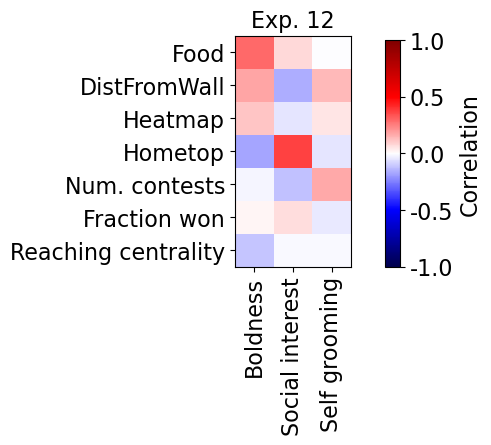

In [79]:
f,ax = plt.subplots(1,len(expnums_to_compare),sharex=True,sharey=True)
if len(expnums_to_compare)==1:
    ax=[ax]
f.set_size_inches(1.5*len(ax),3)
tpx = np.arange(len(indivtestmetrics))
tpy = np.flip(np.arange(len(tocomparemetrics)))
for i,expnum in enumerate(expnums_to_compare):
    a=ax[i]
    raster = a.pcolormesh(tpx,tpy,corr_scores[i].T,cmap='seismic',vmin=-1,vmax=1)
    a.set_title('Exp. '+str(expnum),fontsize=16)
    # highlight significant p value scores
    sigvalues = np.where(pvalues[i]<0.05)
    for sx, sy in zip(sigvalues[0],sigvalues[1]):
        x0,x1 = tpx[sx]-0.5, tpx[sx]+0.5
        y0,y1 = tpy[sy]-0.5, tpy[sy]+0.5
        a.plot([[x0,x1],[x1,x1],[x1,x0],[x0,x0]],[[y0,y0],[y0,y1],[y1,y1],[y1,y0]],
            c='k',linewidth=2,zorder=10)
# tick labels
ax[0].set_xticks(tpx)
[a.set_xticklabels(indivtestmetrics_displaynames,fontsize=16,rotation=90) for a in ax]
ax[0].set_yticks(tpy)
ax[0].set_yticklabels(tocomparemetrics,fontsize=16)
# legend as colorbar
a=ax[-1]
position=f.add_axes([a._position.bounds[0]+1,a._position.bounds[1]+0.0,.1,0.755])
cbar=plt.colorbar(raster,ax=ax,cax=position,orientation='vertical')    
cbar.set_label('Correlation',fontsize=16)
ticks = np.arange(-1,1.1,0.5)
cbar.set_ticks(ticks)
ticks=[str(t) for t in ticks]
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=16)   

plt.savefig(imagedir+'indivtests-corr.pdf')
plt.show()

## Other score comparisons

### Strain- and group-specific comparisons

In [80]:
scores_to_compare.columns

Index(['Boldness', 'BWB-whitefrac', 'ElevX-openfrac', 'Canopy-outfrac',
       'Unfamiliar-Social interest', 'Unfamiliar-Self grooming',
       'Familiar-Social interest', 'Familiar-Self grooming',
       'Unfamiliar2-Social interest', 'Unfamiliar2-Self grooming'],
      dtype='object')

In [81]:
indivtestmetrics = ['BWB-whitefrac', 'ElevX-openfrac', 'Canopy-outfrac','Familiar-Social interest', 'Familiar-Self grooming',
       'Unfamiliar2-Social interest', 'Unfamiliar2-Self grooming']
indivtestmetrics = scores_to_compare.columns
indivtestmetrics_displaynames = [x.replace('-','-\n') for x in indivtestmetrics]

In [82]:
dfjoined = scores_to_compare.join(dfuidlabels)

In [83]:
# normalize each score
for m in indivtestmetrics:
    v=dfjoined[m]
    dfjoined[m] = (v-np.nanmean(v))/np.std(v)
dfjoined.head()

Boldness  BWB-whitefrac  ElevX-openfrac  Canopy-outfrac  \
ID                                                             
BGP -0.436712      -1.240114       -0.019601       -0.022229   
BOP -0.745865       0.403596       -1.422488       -0.386934   
GBP  0.564814      -0.074536        0.258152        1.218943   
GOB  1.240591      -0.867264        1.249963        1.494090   
GOP  2.732005       3.145501        1.648509        1.441210   

     Unfamiliar-Social interest  Unfamiliar-Self grooming  \
ID                                                          
BGP                    1.301769                  0.117222   
BOP                   -0.346610                 -0.479444   
GBP                   -1.350367                  0.543028   
GOB                   -0.729735                 -0.061828   
GOP                   -0.081684                  0.031572   

     Familiar-Social interest  Familiar-Self grooming  \
ID                                                      
BGP                  0.197887               -0.173832   
BOP                  0.475399               -0.038378   
GBP                 -1.278954               -0.640058   
GOB                 -1.304610                2.939593   
GOP                 -0.589978                0.396446   

     Unfamiliar2-Social interest  Unfamiliar2-Self grooming masslabel  \
ID                                                                      
BGP                    -0.529381                  -0.114997       b12   
BOP                    -0.181839                  -0.103001       b10   
GBP                    -0.107145                  -0.993870       b11   
GOB                     0.125024                  -1.007339        a5   
GOP                    -1.044144                  -0.195184        a9   

     GroupMassRank-Exp7 Group GroupG P3gc_ind P1gc_ind linestyle  
ID                                                                
BGP                 5.0    B2     G2        5        3        --  
BOP                 3.0    B2     G2        5        3         -  
GBP                 4.0    B2     G3        6        3         -  
GOB                 5.0    A1     G3        6        0        --  
GOP                 2.0    A2     G4        7        1         -

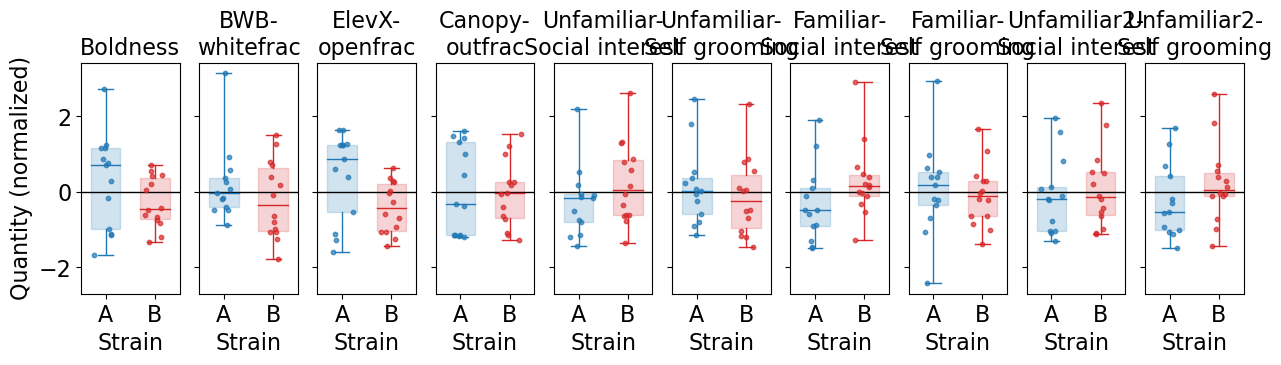

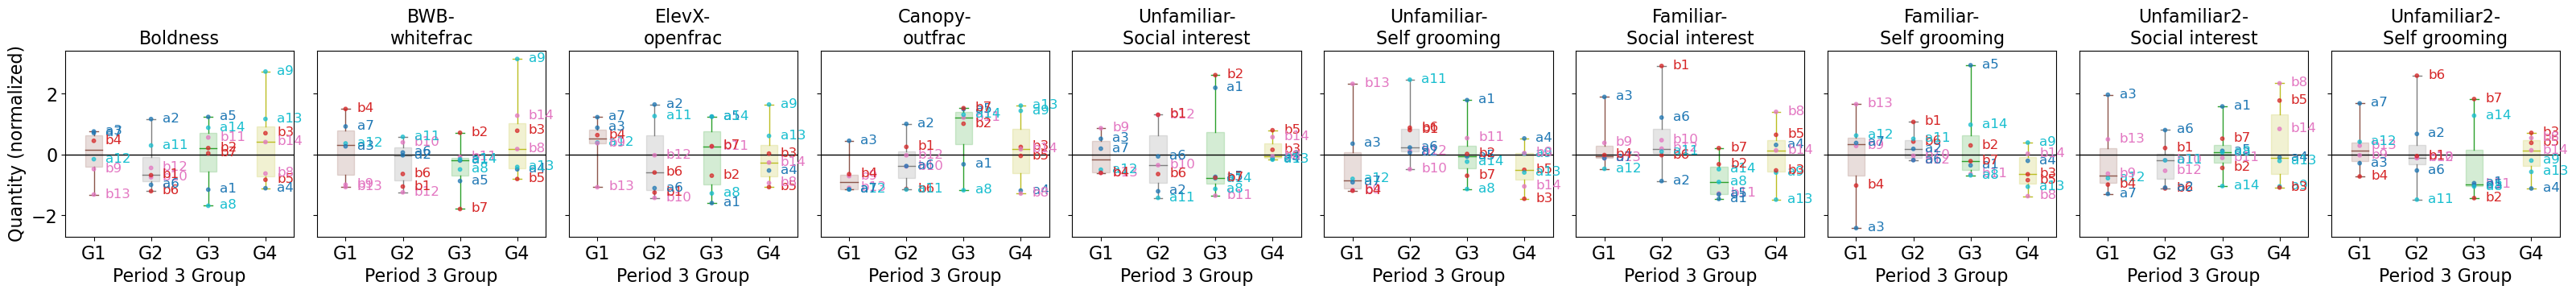

In [84]:
numq=len(indivtestmetrics)
# use the same data, but make different selectors to plot
tpdata = dfjoined[indivtestmetrics].values.T
sel = np.logical_not(np.any(np.isnan(tpdata),axis=0))
tpdata = tpdata[:,sel]

## Strain
f,ax = plt.subplots(1,numq,sharex=False,sharey=True)
f.set_size_inches(1.5*numq,3)
tpcats = np.array([t[0] for t in dfjoined['Group'].values])[sel]
rat.quantitydists(tpcats,tpdata,indivtestmetrics_displaynames,coloroffset=100,
              color=rat.groupcolors[[0,2]],f=f,ax=ax)
ax[0].set_ylabel('Quantity (normalized)',fontsize=16)
[a.set_xlabel('Strain',fontsize=16) for a in ax]
plt.subplots_adjust(wspace=0.2)
# plt.savefig(imagedir+'indivtests-strain-allscores.pdf')
plt.show()

## Original group - not relevant
# tpcats = dfjoined['Group'].values[sel]
# quantitydists(tpcats,tpdata,indivtestmetrics,coloroffset=100,
#               color=rat.groupcolors[0:4],f=f,ax=ax[1])

## P3 group
f,ax = plt.subplots(1,numq,sharex=False,sharey=True)
f.set_size_inches(4*numq,3)
tpcats = dfjoined['GroupG'].values[sel]
ratlabels = dfjoined['masslabel'].values[sel]
ratgroups = dfjoined['Group'].values[sel]
ratlabelcolors = np.tile(np.nan,(len(ratgroups),3))
for i,g in enumerate(rat.groupselnames):
    ratlabelcolors[ratgroups==g] = rat.groupcolors[i]
rat.quantitydists(tpcats,tpdata,indivtestmetrics_displaynames,coloroffset=100,
              color=rat.groupcolors[4:8],f=f,ax=ax,xnoise=0,pointlabels=ratlabels,pointlabelcolors=ratlabelcolors)
[a.set_xlabel('Period 3 Group',fontsize=16) for a in ax]
ax[0].set_ylabel('Quantity (normalized)',fontsize=16)
plt.subplots_adjust(wspace=0.1)
# plt.savefig(imagedir+'indivtests-p3group-allscores.pdf')
plt.show()

### Individual metrics comparisons with specific experiments

In [85]:
# calculate correlations for each experiment
tocomparemetrics = np.concatenate((absolutemetrics,['Num. contests','Fraction won','Reaching centrality']))

expnums_to_compare = np.concatenate((np.arange(1,8),np.arange(10,13)))
expnums_to_compare = [12]
corr_scores = np.tile(np.nan,(len(expnums_to_compare),len(indivtestmetrics),len(tocomparemetrics)))
pvalues = corr_scores.copy()

for e,expnum_to_compare in enumerate(expnums_to_compare):
    dfcomp = rat.dfdata_to_dfpca(dfdata[dfdata['Experiment']==expnum_to_compare],dfdegree)
    dfjoined = scores_to_compare.merge(dfcomp,on='ID')
    for i,s in enumerate(indivtestmetrics):
        for j,m in enumerate(tocomparemetrics):
            x,y = dfjoined[m].astype(float), dfjoined[s]
            sel = np.logical_not(np.isnan(x)|np.isnan(y))
            if np.sum(sel)>2:
                corr,pvalue = scipy.stats.pearsonr(x[sel],y[sel])
                corr_scores[e,i,j] = corr
                pvalues[e,i,j] = pvalue


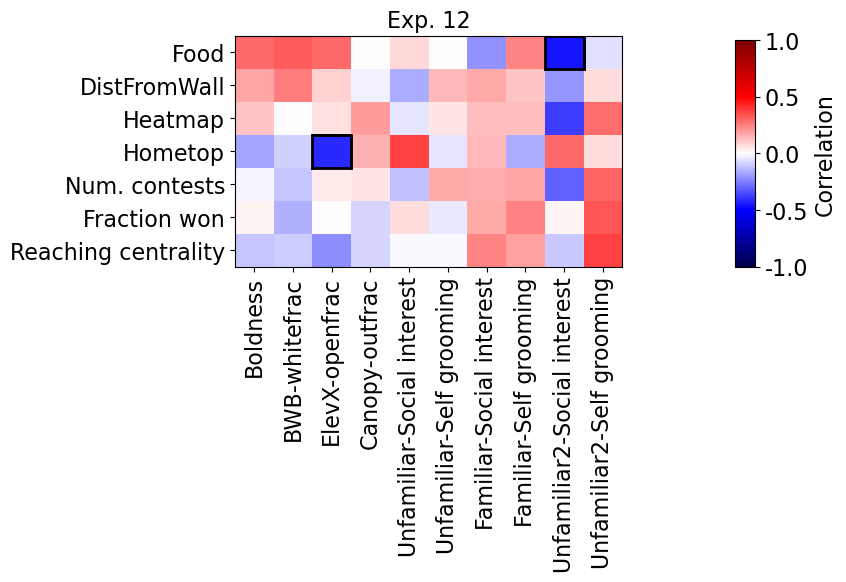

In [86]:
f,ax = plt.subplots(1,len(expnums_to_compare),sharex=True,sharey=True)
if len(expnums_to_compare)==1:
    ax=[ax]
f.set_size_inches(0.5*len(indivtestmetrics)*len(ax),3)
tpx = np.arange(len(indivtestmetrics))
tpy = np.flip(np.arange(len(tocomparemetrics)))
for i,expnum in enumerate(expnums_to_compare):
    a=ax[i]
    raster = a.pcolormesh(tpx,tpy,corr_scores[i].T,cmap='seismic',vmin=-1,vmax=1)
    a.set_title('Exp. '+str(expnum),fontsize=16)
    # highlight significant p value scores
    sigvalues = np.where(pvalues[i]<0.05)
    for sx, sy in zip(sigvalues[0],sigvalues[1]):
        x0,x1 = tpx[sx]-0.5, tpx[sx]+0.5
        y0,y1 = tpy[sy]-0.5, tpy[sy]+0.5
        a.plot([[x0,x1],[x1,x1],[x1,x0],[x0,x0]],[[y0,y0],[y0,y1],[y1,y1],[y1,y0]],
            c='k',linewidth=2,zorder=10)
# tick labels
ax[0].set_xticks(tpx)
[a.set_xticklabels(indivtestmetrics,fontsize=16,rotation=90) for a in ax]
ax[0].set_yticks(tpy)
ax[0].set_yticklabels(tocomparemetrics,fontsize=16)
# legend as colorbar
a=ax[-1]
position=f.add_axes([a._position.bounds[0]+1,a._position.bounds[1]+0.0,.04,0.755])
cbar=plt.colorbar(raster,ax=ax,cax=position,orientation='vertical')    
cbar.set_label('Correlation',fontsize=16)
ticks = np.arange(-1,1.1,0.5)
cbar.set_ticks(ticks)
ticks=[str(t) for t in ticks]
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=16)   

plt.savefig(imagedir+'indivtests-corr-allscores.pdf')
plt.show()